Step 1: Download the dataset from Webhose.IO for all mentions related to the Federal Reserve in the past 30 days between Feb 21 and March 21

In [0]:
import webhoseio, os

In [0]:
webhoseio.config(token="9612e39e-5c4a-4ece-9a8c-b16b6eb9a47b")
query_params = {
"q": "(\"Federal Reserve\" OR \"The fed\" OR \"The ny fed\" OR \"Fed\" OR \"Jerome Powell\") language:english published:>1577865600000 site_type:news spam_score:<0.7",
"ts": "1582309495992",
"sort": "published"
}
output = webhoseio.query("filterWebContent", query_params)
print(output['totalResults'])

97135


In [0]:
feeds = []
for item in output['posts']:
    feeds.append(item)
    print(item['title'], item['url'])

print(len(feeds))

Goldman Sachs / Wall Street: Interests less aligned https://r.search.yahoo.com/_ylt=AwrXgSJVk3de_EoAhzpoAQx.;_ylu=X3oDMTBzdmVvZmlwBGNvbG8DZ3ExBHBvcwMxMAR2dGlkAwRzZWMDc3I-/RV=2/RE=1584923605/RO=10/RU=https://www.lesechos.fr/idees-debats/crible/goldman-sachswall-street-interets-moins-alignes-1187650/RK=2/RS=2WbVON2PVnjwrdIvFdhiCv4iHBw-
Cancer patients turned away from surgeries as hospitals prepare for the worst https://www.king5.com/article/news/cancer-patients-turned-away-from-surgeries-as-hospitals-prepare-for-the-worst/281-4c1fd12a-a47c-4339-8629-aa7791f76cda
Pelosi says no deal yet on stimulus package, as McConnell says leaders are 'very close' - CNNPolitics https://www.cnn.com/2020/03/22/politics/stimulus-package-coronavirus-negotiations-congress/index.html
Treasury secretary says US financial relief to help people, businesses over next 10-12 weeks https://www.wlky.com/article/treasury-secretary-says-us-financial-relief-to-help-people-businesses-over-next-10-12-weeks/31874615
The L

Extract a list of 40,000 records from webhose

In [0]:
count = 399
while count > 0:    
    output = webhoseio.get_next()
    for item in output['posts']:
        feeds.append(item)
    count -= 1
print(len(feeds))

40000


Download the dataset

In [0]:
import json
with open("anly610_fed.json", "w") as myfile:
    for feed in feeds:
        line = json.dumps(feed)
        myfile.write(line)
        myfile.write("\n")

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
from iexfinance.stocks import Stock
from datetime import datetime
import matplotlib.pyplot as plt
from iexfinance.stocks import get_historical_data

Get historical prices for SPY ETF representing S&P 500 stock movements

In [ ]:
def getHistoricalPrices(stock):
    return get_historical_data(stock, start, end, 
                               output_format='pandas', 
                               token="pk_b86d705dca324f28bb38fb0ec90865ee")
 
start = datetime(2016, 1, 1)
end = datetime(2020, 3, 23)
single_stock_history = getHistoricalPrices("SPY")

In [ ]:
### Download the dataset
single_stock_history.to_csv('daily_stock_data1.csv')

We load the news articles dataset first

In [1]:
import json

json_data=open("anly610_fed.json").readlines()
feeds_read_from_file = []
for line in json_data:
    feeds_read_from_file.append(json.loads(line))
print(len(feeds_read_from_file))

40000


We append the list of articles to a dataset

In [2]:
data = []
i = 0
for record in feeds_read_from_file:
    record['id'] = i
    # print(record['id'], str(record['title']))
    i+=1
    data.append(record)

Step 2: We deduplicate the dataset using Word2Vec model

In [3]:
import numpy as np
from gensim.models import KeyedVectors

model_path = 'C:/Users/subha/Downloads/'
# model_path = '/root/input/'

In [4]:
def load_wordvec_model(modelName, modelFile, flagBin):
    print('Loading ' + modelName + ' model...')
    model = KeyedVectors.load_word2vec_format(model_path + modelFile, binary=flagBin)
    print('Finished loading ' + modelName + ' model...')
    return model

model_word2vec = load_wordvec_model('Word2Vec', 'GoogleNews-vectors-negative300.bin.gz', True)

Loading Word2Vec model...
Finished loading Word2Vec model...


In [5]:
def vec_similarity(input1, input2, vectors):
    term_vectors = [np.zeros(300), np.zeros(300)]
    terms = [input1, input2]
        
    for index, term in enumerate(terms):
        for i, t in enumerate(term.split(' ')):
            try:
                term_vectors[index] += vectors[t]
            except:
                term_vectors[index] += 0
        
    result = (1 - spatial.distance.cosine(term_vectors[0], term_vectors[1]))
    if result is 'nan':
        result = 0
        
    return result

In [6]:
# function checks whether the input words are present in the vocabulary for the model
def vocab_check(vectors, words):
    
    output = list()
    for word in words:
        if word in vectors.vocab:
            output.append(word.strip())
            
    return output

In [7]:
# function calculates similarity between two strings using a particular word vector model
def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))
    try:
        output = vectors.n_similarity(s1words, s2words)
    except:
        output = 0
    return output

Step 2a: We delete all entries from the dataset with similarity scores more than 0.8

In [9]:
for rec in range(len(data)):
    index1 = rec
    print(index1)
    title = data[index1]['title']
    # feed_hash = Simhash(str(title), f=64)
    # dup_indices = index.get_near_dups(feed_hash)
    for element in range(index1+1, len(data)):
        try:
            if calc_similarity(str(title), data[int(element)] ['title'], model_word2vec) > 0.80:
                data.pop(element)
        except: 
            pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977


8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616


10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
1021

11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
1157

12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
1294

14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
1431

15511
15512
15513
15514
15515
15516
15517
15518
15519
15520
15521
15522
15523
15524
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
1567

16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
1704

18243
18244
18245
18246
18247
18248
18249
18250
18251
18252
18253
18254
18255
18256
18257
18258
18259
18260
18261
18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
1840

19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
1977

20982
20983
20984
20985
20986
20987
20988
20989
20990
20991
20992
20993
20994
20995
20996
20997
20998
20999
21000
21001
21002
21003
21004
21005
21006
21007
21008
21009
21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115


IndexError: list index out of range

In [26]:
len(data)

21115

Step 2b: We download this deduped dataset for subsequent analysis

In [11]:
import json
with open("anly610_fed_deduped_t3.json", "w") as myfile:
    for data1 in data:
        line = json.dumps(data1)
        myfile.write(line)
        myfile.write("\n")

We load this dataset now

In [21]:
import json

json_data=open("anly610_fed_deduped_t3.json").readlines()
feeds_read_from_file1 = []
for line in json_data:
    feeds_read_from_file1.append(json.loads(line))
print(len(feeds_read_from_file1))

21115


The dataset of news despite having 40,000 records to begin with only seems to have data from March 12th

In [406]:
feeds_read_from_file1[21114]['published']
# feeds_read_from_file1[0]['published']

'2020-03-12T02:00:00.000+02:00'

In [404]:
i = 0
for record1 in feeds_read_from_file1:
    record1['id'] = i
    print(record1['id'], str(record1['thread']['title']))
    i+=1
    

0 Goldman Sachs / Wall Street: Interests less aligned
1 Cancer patients turned away from surgeries as hospitals prepare for the worst
2 Pelosi says no deal yet on stimulus package, as McConnell says leaders are 'very close' - CNNPolitics
3 Treasury secretary says US financial relief to help people, businesses over next 10-12 weeks
4 The Latest: Prison riot in Colombia leaves 23 dead
5 Alexandria Ocasio-Cortez calls Justice Department emergency proposals 'abhorrent'
6 As crisis deepens, Congressional rescue deal teeters
7 Why We Are Deliberately Allowing Our Economy To Go On A Downward Spiral
8 This Grain Cures Cholesterol (better than statins)
9 McConnell: Despite continued negotiations, coronavirus vote will happen Monday: 'The wheel has to stop at some point'
10 Everyone Wanting To Buy Suggests The Bear Still Prowls
11 How a ‘Debt Jubilee’ + mining could be a path to coronavirus recovery
12 EUR/USD Forecast March 23-27 – Euro Crumples as Greenback Sparkles
13 A coronavirus vaccine is

147 De Blasio: If Trump does not act on coronavirus outbreak, 'people will die'
148 De Blasio: If Trump does not act on coronavirus outbreak, 'people will die'
149 Senate Races to Finish Virus Stimulus Bill: Congress Update
150 Explaining Clear-Cut Products In Casino
151 De Blasio: If Trump does not act on coronavirus outbreak, 'people will die'
152 With temperature checks and face masks, Russians protest amid coronavirus
153 De Blasio: If Trump does not act on coronavirus outbreak, 'people will die'
154 De Blasio: If Trump does not act on coronavirus outbreak, 'people will die'
155 Ranking the 10 Greatest Football Adverts in History | 90min
156 Ask the Rational Investor: Remain calm amongst the fog
157 Parliament to be recalled to approve $82B COVID-19 financial aid package, Trudeau says
158 Parliament to be recalled to approve $82B COVID-19 financial aid package, Trudeau says
159 Not time for state of emergency, Trudeau says, but Parliament asked to pass COVID-19 aid
160 Not time for

273 Ask HN: How bad will the 2020 economic crisis be?
274 Fed's Bullard: Coronavirus shutdown not a recession but an investment in survival
275 Coronavirus Economic Measures to Help Half of US Workforce and Small Businesses - Mnuchin
276 The new wave of old technology, yesterday's devices making a comeback technology
277 Here’s How You Can Help Your Neighbors During the Coronavirus Pandemic
278 As crisis deepens, Congress close on economic rescue deal - Las Vegas Sun Newspaper
279 Massachusetts Financial Services Co. MA Has $5.86 Million Stock Position in Enerplus Corp (NYSE:ERF)
280 Economist warns economy needs ‘blanket’ fiscal support and a ‘big problem’ if the virus persists
281 COVID-19: Welcome to the New Dark Ages
282 Treasury Market in Tumult Stares Down $340 Billion More Debt
283 Coronavirus pandemic triggers spike in gun sales
284 Banks Should Defer Consumer Debt to Save the Economy
285 S&P 500, DAX 30, ASX 200 Forecasts for the Week Ahead
286 Keep Calm, Bear Markets Are Temp

531 A Different Phrase For Bear Market Is Sale
532 Uivo: Koronavirus i sport  pozitivan bivi igrač Mančester junajteda - B92.net
533 How Did Pearl Harbor Affect The Dow Jones Index?
534 Book review: 'The Falcon Thief' centers on heroic birder and merciless thief
535 Italy, pandemic’s new epicentre, has lessons for the world
536 Coronavirus Rescue Bill Moving Toward a Final Senate Vote Monday -- 3rd Update
537 Italy’s coronavirus death toll feeds fear of what lies ahead in Europe and the US
538 Coronavirus Cases Top 308,000 As U.S. Covid-19 Infections Surge Above 27,000; Stimulus May Hit $2 Trillion Amid Coronavirus Market Crash | Investor's Business Daily
539 London,uk: Prison Makes Us Sick!
540 Oxford schools provide free lunches to area children
541 FDA approves new coronavirus test that can have 'results within hours' instead of days
542 Gov. Cuomo warns New York coronavirus crisis could last months News
543 Trump ramps up after dire report, media also getting low marks
544 As vi

842 Trump campaign calls out NBC reporter before coronavirus briefing
843 Exclusive: Goldman injects $1 billion into own money-market funds after heavy withdrawals
844 Exclusive: Goldman Injects $1 Billion Into Own Money-Market Funds After Heavy Withdrawals
845 New Jersey 'stay at home' order issued to halt coronavirus spread, following footsteps of several states
846 New York disaster declaration approved to fight coronavirus
847 New Jersey 'stay at home' order issued to halt coronavirus spread, following footsteps of several states
848 Senate Dems propose additional $200 in monthly Social Security benefits, amid coronavirus outbreak
849 New Jersey 'stay at home' order issued to halt coronavirus spread, following footsteps of several states
850 Grocery stores hiring more staff, offer wage boost as B.C. adapts to COVID-19 buying habits
851 Grocery stores hiring more staff, offer wage boost as B.C. adapts to COVID-19 buying habits
852 Grocery stores hiring more staff, offer wage boost a

1012 The 1-, 3-, 6- and 12-Month U.S. Dollar (Eurodollar) LIBOR Rates Fixed Higher Today
1013 Coronavirus killing more than a person an hour in NYC
1014 Trudeau not declaring national state of emergency for COVID-19 yet
1015 Isoptin | Purchase Generico Cheap
1016 Oregon Dem Wyden warming to GOP plan for coronavirus relief checks, Kudlow says
1017 Peggy Grande: Americans will survive uncertainty of coronavirus – We are stronger than we realize
1018 Russia Deporting Chinese Who Violate Coronavirus Quarantine
1019 Corona: Call for urgent steps to avoid disruption of food and feed supply in Europe
1020 POLITICAL NOTEBOOK: State's response to COVID-19 keeps ratcheting up
1021 NUFC End of the Decade series: The best match of the 2010s
1022 Downtown Journal: Charlie and Marty, Leaders for Tough Times
1023 Shared Inventory Slot
1024 Michael Levin: Tom Brady leaves Patriots for Tampa Bay Buccaneers – and this is the person to blame
1025 The coronavirus crisis calls for a real leader — and it’s 

1157 Amid tension, police shooting report says suspect raised gun
1158 Arcosa Inc (NYSE:ACA) CEO Antonio Carrillo Acquires 15,000 of Stock
1159 UK Govt to Fund Pay for Closed Businesses – But EU Trying to Block Aid
1160 Amid Tension, Police Shooting Report Says Suspect Raised Gun
1161 SC man lied about positive coronavirus test to get paid vacation: sheriff
1162 Cain’s Ballroom to host live streaming benefit concert
1163 March 2020 Film Thread
1164 Lightning Fill In The Blank
1165 Lightning Fill In The Blank
1166 Lightning Fill In The Blank
1167 Bank of America lays out the 6 things that need to happen for the stock-market crash to truly end — and warns only 4 have occurred so far
1168 CORONAVIRUS: Third Federal Closes Local Boca Branch - BocaNewsNow.com
1169 Division 2, The
1170 Indian Musicians Unite for a ‘We are The World’-like Project on World Water Day
1171 Finger-pointing at China will not unite the global community - Chinadaily.com.cn
1172 How Mortgages Can Ease the Downturn
11

1323 Co-op donates £1.5m of food to hunger charity FareShare
1324 Joe Biden Jumped at the Chance to Help George W. Bush Sell the Invasion of Iraq - Jacobin magazine
1325 Businesses banning banknotes, asking customers to use credit, debit cards
1326 Effect of economic crisis on America’s small businesses [slides]
1327 Coronavirus latest: Three-quarters of the country not strictly following Government advice
1328 States Can’t Shut Down Non-Essential Businesses Without Harming Essential Ones
1329 Central banks take further steps to boost U.S. dollar liquidity
1330 Businesses banning banknotes, asking customers to use credit, debit cards
1331 Robert W. Baird Cuts Boeing (NYSE:BA) Price Target to $183.00
1332 Chick-fil-A Delivers 1,000 Free Meals to Hospital Staff Amid CCP Virus Shutdown
1333 Markets continue to trade amid virus
1334 The undervalued heroes of the coronavirus crisis need our thanks – and our support | Owen Jones | Opinion
1335 Meghan Markle news: Duke and Duchess of Sussex i

1511 'No matter what happens, people want to listen to new music' – Ian Smith of Last Night From Glasgow
1512 Study reveals protein that removes belly fat before it sticks to you
1513 Does Bitcoin Have Intrinsic Value or Is It Based on Thin Air?
1514 Governors take the lead as feds scramble to catch up in responding to coronavirus
1515 Coronavirus - the urgent product recalls you need to know about
1516 COVID-19's Devastating Effects on Jobs and Businesses
1517 Kerr Co. SWCD offers spring fish sale May 15
1518 Move that bus!
1519 Market slide resumes in worst week for Wall Street since 2008
1520 The Impact of Effective Handwashing Against Infection
1521 Staffers deliver more meals every day to kids out of school
1522 Efforts to ensure Hawaii’s kupuna are fed ramp up while many eateries are shutting down
1523 PFAS levels in Cairo water decline - Greene County - hudsonvalley360.com
1524 Albertsons plans plexiglass barriers, ‘appreciation pay’ in COVID-19 response
1525 Feds label Deere & 

1796 Why I quit my poultry business to rear pigs
1797 Consumption of Cattle Hide Singed with Scrap Tyre is Detrimental to the Liver, Heart and Kidney of Rats
1798 Weekly Wrap: Letter From Our CEO and How Congress Can Curtail the Economic Crisis
1799 Kudlow Quotes Relief Bundle Might Be $2 Trillion ... - Job Search Tips
1800 Do Saudi Arabia, Russia Target US Shale Industry?
1801 U.S. markets wrap up worst week since the 2008 financial crisis
1802 You Can't Limit Yourself In a Market Like This
1803 Eric Bischoff on Claims He Called Steve Austin Unmarketable in WCW, Austin's Anti-WCW Skits in ECW | 411MANIA
1804 Credit reporting act #Credit #reporting #act – CREDIT
1805 Albertsons companies announces $2 hourly pay increase to employees - Merced Gateway News
1806 It’s all about blood in ‘Kingdom’ | Inquirer Lifestyle
1807 SPDR S&P 500 Buyback ETF (NYSEARCA:SPYB) Plans Quarterly Dividend of $0.61
1808 How COVID-19 Impacts Homeowners and Home Buyers | Find My Way Home
1809 On coronavirus and

1944 Trump angrily defends his handling of pandemic
1945 How to Read Labels
1946 Coronavirus-related unemployment claims risk wiping out state funds.
1947 Top Ten: Weekend reads: The best ways a supervision can assistance as a coronavirus shuts down businesses
1948 Okolona Schools feed kids in time of coronavirus
1949 Elizabeth Warren And Mark Cuban Say No More Reckless Buybacks If Company Takes Government Bailout Money
1950 Liberal NPCs Hate Russia, Conservative NPCs Hate China
1951 Woman goes into labor, delivers baby in toilet paper aisle at Walmart
1952 Crafts for kids who suddenly have lots of time on their hands
1953 Lamont Orders Non-essential Businesses to Close
1954 Dow loses 1/3 of value in a month as another heartless trade week ends
1955 Coronavirus live updates: COVID-19 cases in Delhi rise to 20; India's tally at 259
1956 Free Lunches During School Closure
1957 Nutrients in AlgaeCal Plus That Support Your Immune System
1958 Dr. Manny Alvarez says he's 'bullish' on anti-ma

2140 The impacts of Coronavirus on the financial markets – Update from March 20 by Esty DWEK from Natixis Investment Managers Solutions
2141 Coronavirus Report that Prompted Stronger U.S. Action: 1M Deaths, Even with Extreme Measures
2142 Bulldog in England gives birth to 20 puppies News
2143 February home sales jump to highest in over a decade, but big drop expected
2144 Worst week since 2008: US stocks hit hard as Covid-19 keeps hammering world of finance
2145 NBC's Peter Alexander Defends 'False Hope' Question at Virus Briefing
2146 1,300 people under watch as COVID-19 cases hit 12
2147 Fed Govt allays fears of fertiliser scarcity
2148 A Legal Look at the Drugs Being Used to Potentially Treat Coronavirus
2149 US stocks suffer worst week since 2008 with investors still unsold on efforts to help hit economy
2150 Audio: Authorities Begin Economic Lockdown & Helicopter Money Drops
2151 Letter: Espousing typical liberal ideas
2152 Donald Trump Dismisses Mayor Bill de Blasio: 'I'm Not Dea

2380 Joni Ernst Calls for Unused Presidential Campaign Fund to Fight Coronavirus
2381 Euro rallies against dollar after new three-year low
2382 U.S. Stock ETFs Slip Following Tough Government Measures to Contain Coronavirus
2383 In a topsy-turvy time, TV that brings some laughs (Stephen King aside)
2384 China's relationship with WHO chief in wake of coronavirus outbreak under the microscope
2385 Wild and beautiful life of Hunter carer queen
2386 Commentary: Dishing on the language of food
2387 After run of bad seasons, farmers warn of future food shortages without cash help
2388 UNFI increases wages during pandemic
2389 Bangladesh Bank oblivious to coronavirus
2390 Nelson Tasman business leaders offer 'drop in-type' centre
2391 In the midst of coronavirus, Grand Forks is 'doing unto others'
2392 A&E doctor urges London residents ‘lock-down now’ as first London hospital declares critical emergency over coronavirus
2393 Takeout Review: Big Fin Seafood Kitchen
2394 Feds tell Colorado and 

2636 The dark true story of Netflix’s Tiger King Joe Exotic who kept hundreds of lions and hired a hitman to kill his rival
2637 SE Asia Stocks-Most markets rally as volatile week ends, Thailand leads gains
2638 Ex-Husker Shields donating 96,000 meals in Kansas City
2639 Treasury: Tax deadline extended from April 15 to July 15
2640 Palace hopes private firms, too, will pay contractual workers during quarantine | Inquirer
2641 Treasury: Tax deadline extended from April 15 to July 15
2642 Yields down but stable as emergency economic measures take hold
2643 New York State has 40 percent of US coronavirus cases
2644 NY Fed's GDP Nowcast for Q1 2020 drops to 0.1% from 1.1%
2645 Cabbages and kings: how Georgian royals brought continental food to the British menu
2646 Murder, madness and tigers: behind the year's wildest Netflix series | Television & radio | The Guardian
2647 Coronavirus: How to limit the impact on poorest pupils
2648 Feds boost efforts to secure medical gear supplies as COVI

2752 Stocks open higher on Wall Street at end of a brutal week
2753 Lexology learnings
2754 5 Toys to Quell Tantrums While You’re Stuck Inside
2755 DC Mitigates Hunger, Education Woes Amid Pandemic
2756 More than Just a Virus
2757 California wakes up to strictest coronavirus measures in USA: Here are new rules
2758 Let’s Hope the Bank Stress Tests Were Up to It - BNN
2759 Coronavirus update: Tax Day, Mexico border, California lockdown, NY
2760 Janney’s Jerry Lombard – Coronacrash update with Tony Sirianni
2761 The world is spiraling toward a 'wartime economy.' Here's what experts say that will look like for America in 2020.
2762 Feds announce new reprieve for income taxes
2763 Senate Republicans include $1,200 cash payments for Americans
2764 Senate Republicans' coronavirus relief bill to eliminate withdrawal penalty for $100,000 retirement accounts
2765 Doctors Say Shortage of Protective Gear Is Dire
2766 The global economy and its impact on startups in the time of COVID-19
2767 Docto

2961 Gold Prices Rise 2% On Safe-haven Demand
2962 National Pork Board and North American Meat Institute Partner to Celebrate BOTH National Deli Meat Month AND National Nutrition Month
2963 Open For Business: The AVA Will Soldier On Through The Crisis
2964 FBI Adjusts To Persevere Through Pandemic As Much Of America Shuts Down
2965 Message From the President: Thanks all Around and Our Plan for the Summer Term
2966 Latest on the coronavirus: Worldwide deaths exceed 10,000 - World News
2967 The 15 best classic rock albums to own on vinyl
2968 Arbnco wins govt contract for Digital Energy Efficiency Platform prototype
2969 Late try sees Bradford Bulls Women lift Natalie Harrowell Cup
2970 Looking for a blues festival this weekend? Here's one you can view from your living room
2971 Training for Wimbledon ballboys and girls on hold but chiefs insist decision on cancelling event will not be made yet
2972 Mid-session analysis hooly-news.com Wall Street – Investors awaiting the peak of the pand

3166 Brexit warning: David Davis insists 'EU won't be able to stop us" as he hits out at France | UK | News
3167 Why America’s financial plumbing has seized up
3168 David Stockman says coronavirus is sparking a financial crisis, warns ‘Wall Street is toast’
3169 How Visa became a tip dog in tellurian finance
3170 EU open to 'coronabonds' to cushion economic fallout
3171 Food banks strapped for resources, volunteers
3172 Water theft a growing concern in increasingly-dry Spain
3173 Pound US Dollar Exchange Rate Surges 2.54% as California Coronavirus Lockdown Reinforces US Recession Threat
3174 COVID-19 is hurting the bottom line of a social ho
3175 5 nature walks to do around Dublin (while social distancing)
3176 #982: How To Save The Economy Now
3177 Editorial: Washington’s coronavirus reflex: Spend, spend, spend
3178 Supermarkets to join forces to feed the nation
3179 Daily Market Comment – Markets calmer after deluge of stimulus; dollar retreats
3180 Deeply Embattled OXY Stock Is Abou

3310 Dayton, other jurisdictions say they will need a bailout
3311 The Elites Are Bailing Out the 1% at Your Expense Again
3312 Fed Govt tasks stakeholders on sustainable consumption
3313 Coronavirus deaths in Italy overtake China as economic damage mounts
3314 Ray Dalio predicts US companies will lose $4 TRILLION in coronavirus recession
3315 How will the global stock market recover? Current Affairs Opinion
3316 Governor issues statewide order to stay home
3317 California orders Residents to stay at home in Bid to Blunt Pandemic
3318 Australia central bank buys $2.9 billion of bonds in first round of unlimited QE
3319 Coronavirus outbreak: India reports fourth death, total cases at 173 | Business Standard News
3320 Wall Street rebounds as aid plans multiply
3321 InterManager Daily News 20.03.2020
3322 Sensex, Nifty march ahead in broader rally; Europe opens in green
3323 NWA Letters to the Editor
3324 Forum Post: RE: export and import item master data in GP
3325 Mariners latest club t

3519 ZOSYN (piperacillin sodium and tazobactam sodium) injection, powder, lyophilized, for solution ZOSYN PHARMACY BULK PACKAGE (piperacillin sodium and tazobactam sodium) injection, powder, lyophilized, for solution ZOSYN IN GALAXY CONTAINERS (tazobactam sodium and piperacillin sodium) injection, solution [Wyeth Pharmaceuticals LLC, a subsidiary of Pfizer Inc.]
3520 CONFER: Negative interest rates would steal from your bank account
3521 Keiser Report | From Lost Generation to Last Generation
3522 How Congress can and cannot cushion the economic blow of the coronavirus
3523 Gold Gains But Set for Weekly Drop as Rush for Cash Continues Amid Fallout from Coronavirus Pandemic
3524 SULFASALAZINE tablet, delayed release [Greenstone LLC]
3525 Formations of, Acquisitions by, and Mergers of Bank Holding Companies
3526 Could copper help replace antibiotic use in broilers?
3527 Federal Reserve: Recent Actions in Response to COVID-19
3528 Taking Covid-19 lightly
3529 ForexLive Asia FX news wrap: 

3654 Reserve Bank of Australia and US Federal Reserve Announce Swap Arrangement
3655 Detroit Catholic Archdiocese Kicks Out LGBTQ Group
3656 Coronavirus UK: Gary Neville says ‘a festival of football’ can bring hope and joy’ after outbreak – Daily Mail
3657 Lowe’s Companies, Inc. (NYSE:LOW) Shares Acquired by Red Cedar Management LP
3658 Coronavirus, testing, Newsom, Trump, travel, toilet paper: Thurs news
3659 Tom Hanks' sister says actor is 'not good, but still OK' amid coronavirus diagnosis
3660 Crow Agency assembles emergency response team amidst COVID-19 Pandemic | Regional News
3661 Why we are staying out of the market
3662 Amy Klobuchar Demands Vote-By-Mail, Calls it 'Time-Tested, Reliable'
3663 Food distribution changes for students
3664 Wall Street regains some lost ground in a less rocky day
3665 US conglomerates see borrowing costs spike
3666 NHL 20 Caps simulation: Ovechkin nets goal No. 50 in blowout win over Blue Jackets
3667 Helping to keep students in need fed during cor

3857 Live updates: U.S. stock markets poised to pop after extremely volatile week - The Washington Post
3858 Proposal to send checks to Americans reignites calls for universal income - The Washington Post
3859 Jets players donate $100,000 to local food organization amid COVID-19 - Sportsnet.ca
3860 Feds Release Guidance on Defining Critical Infrastructure Including Water-Wastewater | CWEA Water News
3861 4x4 Adventure Series: Flinders Ranges, SA (Part 2):
3862 Market report: Sports Direct and Travis Perkins sound virus alarm
3863 The Wild Residents at Redwings Horse Sanctuary | Raising Livestock
3864 Coronavirus: Miami Pets Bring Joy to Those Working From Home | Miami New Times
3865 CrowdStrike Holdings Inc (CRWD) Q4 2020 Earnings Call Transcript | The Motley Fool
3866 We May Be Entering a New Paradigm Shift in Asset Allocation - RealMoney
3867 Now’s a good time to spend extra hours with nature - Outdoornews
3868 Watch: Rabbi Paysach Krohn Speaks to This Week's Bar Mitzvah Young Men (V

4013 VA secretary: Trump ordering Navy hospital ship to NYC shows commitment to help his hometown
4014 Fed's actions starting to work, Daly says
4015 Dysfunctionality in a Coronavirus Winter
4016 Mortgage Rates Jump, but Waiting for Them to Fall Again Is a Huge Gamble
4017 ETF of the Week: Pacer TrendPilot US Bond ETF (PTBD)
4018 Fed's Daly Says 'Our Tools Are Starting to Work' in Markets
4019 Stifel Financial Corp Has $7.37 Million Position in Check Point Software Technologies Ltd. (NASDAQ:CHKP)
4020 Judge Andrew Napolitano: Coronavirus fear lets government assault our freedom in violation of Constitution
4021 US jobless claims rise to 2 1/2-year high,
4022 Let’s Get Real about RPA
4023 South Padre Island in Texas limits beach gatherings as spring beakers gather amid coronavirus
4024 Drive-thru free pet food pickup to be offered by Helen Woodward Animal Center
4025 ECB brings 750 bn euro bazooka to virus fightback
4026 Jesse Watters: Trump uses 'Chinese virus' phrase to 'make sure tha

4297 How major US stock indexes fared Thursday
4298 Elephants get drunk on wine after sneaking into farm in search for food
4299 GDP, Nike Earnings Try to Wrestle Spotlight From COVID-19
4300 Donald Trump: American 'Corrupt Media' Media Siding with China
4301 Number Of COVID-19 Cases In Maine Reaches 52
4302 Truck found filled with 18,000 pounds of stolen toilet paper
4303 The Evening Blues - 3-19-20
4304 Stock markets extend gains as policymakers pull out all the stops
4305 Insider Trading Legal Stock Market Purchase Information Membership Launched
4306 US recession chances now at 80% despite Federal Reserve's emergency moves: Reuters poll
4307 Numbers show how early coronavirus hit the economy
4308 Asymptomatic Cavite Governor says sorry for taking COVID-19 test amid shortage
4309 How to get a career in animal care?
4310 Rockford Distillery Given "OK" By Feds To Produce Hand Sanitizer
4311 Yukonomist: Budget 2020: Borrowing to keep the good times rolling
4312 With all else scrambled,

4478 More foster homes needed as local animal shelters seeing some 'scary trends' during pandemic
4479 Governments quarantine banknotes as coronavirus puts ‘dirty’ money in spotlight
4480 Coronavirus: Alberta distilleries make hand sanitizer amid COVID-19 pandemic
4481 Emerging Economies to see Boom in Off-Grid Renewables Wood Mackenzie - GFC Media Group
4482 Looking back & looking ahead: WKU Football's unforgettable turnaround
4483 Long Beach theatres go dark amid virus scare
4484 Nutrients for Kids: How to make sure your kids are getting enough
4485 Chinas yuan unshakable in the face of global recession
4486 Coronavirus closes schools, alters schedules
4487 1985 Document Shows the Destruction of the White Man, Christianity and Satan's Arrival, which is Now
4488 Corona virus updates: Wuhan reports first day with zero new cases
4489 Trump Signed Pelosi’s Coronavirus Stimulus Bill Into Law — But When Are Taxpayers Getting Their Relief Checks?
4490 Kim Jong-un Orders Hospital Built, Deni

4645 Parental diet affects sperm and health of future offspring
4646 FDA Seeks To Expand Treatment For Coronavirus As Part Of White House Response
4647 Grassroots Group Helps Keep LIC Fed Amid Coronavirus Spread | Astoria, NY Patch
4648 Donald Trump: Chloroquine for Coronavirus Showing 'Tremendous' Results
4649 Restaurants, bakeries adapt to new ways of selling
4650 Restaurants, bakeries adapt to new ways of selling
4651 Joe Minarik on how banks are moving to cushion the economic impast of COVID-19
4652 Stocks fight to protect Trump-era gains
4653 Virus poses a test: Can fractured Washington still 'go big'?
4654 AFI cancels Friday's Indian Grand Prix, called-off next month's Fed Cup after ministry directive
4655 This Massacre Explains Why China Can't Forgive Japan For World War II
4656 975: What The Hell Happens Now?
4657 Iran woman, 103, purportedly survives coronavirus as country’s death toll spikes to 1,135
4658 Donald Trump Says Malaria Drug for Coronavirus Has Been Approved by FDA

4872 Wall Street see-saws up and down as volatility retains grip
4873 USDA to partner with rural schools to provide one million meals per week to schools shut by COVID-19
4874 More Chicago Restaurants Offering Delivery, Curbside – Day 4
4875 Stock Market In Flux As Investors Weigh Latest Coronavirus Impacts
4876 Titulek: 30 je naprosto adekvatní! (Téma: Koruna dnes oslabuje nad 28 Kč za euro, je tak nejslabší od ledna 2015. Bulharská měna letos proti euru prakticky drží svoji hodnotu)
4877 Bank of England cuts interest rates again in response to coronavirus and sends the pound soaring from a 35-year low
4878 Sault businesses assisting locals during coronavirus
4879 Police show up at Louisiana church that was defying coronavirus state order
4880 Tyson Foods, Inc. (NYSE:TSN) Given Average Rating of “Hold” by Analysts
4881 Coronavirus: Global spending overtakes financial crisis response
4882 Achieving Corporate Purpose and the Role of Long-Term Incentive Compensation in Doing So
4883 Coro

5062 In a Time of Crisis, Let's Stand Together
5063 Pelosi calls on Trump to speed production of critical medical equipment
5064 THE LATEST: 2 deaths in CT now linked to coronavirus - WFSB
5065 Proposed Revisions to the Volcker Rule: Prohibitions and Restrictions with respect to Covered Funds
5066 Can Our Shuttered Auto Plants Make Ventilators for Coronavirus Patients? And Will the Government Let Them?
5067 Sheer Panic: Futures Surge, Tumble, Surge, Tumble…
5068 Rate cut welcomed, vital stimulus for economy and property during this crisis
5069 Covid-19: Do not empty your bank account
5070 Standing At The Precipice Of A Financial Collapse: Time For A 21st Century Pecora Commission
5071 Trump is right about sending Americans $1,000 — but he needs to act now
5072 The stock market may bottom long before the coronavirus epidemic peaks, analysts say
5073 The small-government case for giving everyone a big check
5074 Coronavirus pandemic means ‘new normal’ for employers, employees
5075 Fed es

5292 Himcolin | Next Day No Rx
5293 Jobless Claims, Factory Gauge Show Virus Filtering to U.S. Data
5294 What is the Dow Jones today?
5295 STI dives to near 2,300 as US dollar soars
5296 Scientists Uncover World's Oldest Fossil of a Modern Bird
5297 Preppers, once mocked, say they were ready for coronavirus crisis
5298 Coronavirus Update: Relief Law, Car Plants to Close and Fed Measures
5299 US: Sizable rise in jobless claims expected – TDS
5300 'Helicopter Money' Is The New Orthodoxy Leaving Europe In An "Inescapable Negative Feedback Loop"
5301 Unions comment on school closures
5302 USD/JPY Technical Analysis: When Will it be Possible to Sell? - 19 March 2020
5303 Central banks deploy trillions to keep economy running
5304 What the markets imply about the economic impact of the coronavirus – The Economist
5305 ‘Does Anyone at Google Even Use Android Auto?’ Users Fed Up with Bugs Scream
5306 Markets trade in narrow range from gains to losses
5307 The risk of a depression in the US is 

5549 Fed Moves Show Urgency of Coronavirus Response
5550 Looming storm demands decisive action from Canadian leaders
5551 Pink Floyd's Roger Waters Gets Political With the Chronicle
5552 Dehydration in Children
5553 Acts of kindness disinfect the world
5554 Exchange Rates Daily Today 19.03.2020: Pound Sterling Crashes to Historic Lows, Euro Free-Falls as King Dollar Ultimate Safe Haven Currency
5555 Rasuvo (Methotrexate Non-pyrogenic Solution for a Single Subcutaneous Injection) - updated on RxList
5556 Bond markets buckle, investors shrug off central banks steps
5557 Coronavirus has made things crazy and scary and they were already crazy and scary before! | First Dog on the Moon | Opinion
5558 Fed Govt to Sudan: allow stranded Nigerians to return home
5559 JS Wright gets £11m M&E package on Bouygues' Bristol tower
5560 Coronavirus: Asia Pacific recovery depends on return of consumer demand
5561 WATCH: Rand falls to weakest level ever as the dollar flexes
5562 Square : Wins OK For Bank

5766 Hsiang ju, used in TCM, protects the liver from damage, prevents lipid accumulation
5767 Asian Stocks Lose Early Gains Amidst Ongoing COVID-19 Fears
5768 Standing At The Precipice Of A Financial Collapse: Time For A 21st Century Pecora Commission
5769 Coronavirus triggers massive spike in firearms and ammunition sales
5770 Quantitative easing: what is it and why is the Reserve Bank of Australia considering it?
5771 Overview of the EUR/USD pair. March 19. The crisis will continue to worsen until the coronavirus is defeated
5772 As the U.S. struggles through COVID-19 response, Nebraska is 'unique place'
5773 AFI Cancels Indian GP, Postpones Next Month's Fed Cup After Sports Ministry Directive
5774 Federal Reserve Board broadens program of support for the flow of credit to households and businesses by establishing a Money Market Mutual Fund Liquidity Facility (MMLF)
5775 Bristol food pantries face major challenges amid coronavirus fears
5776 U.S. FED SAYS WILL CREATE MONEY MARKET MUT

6051 Rate cut: there could be more | Business Recorder
6052 JPMorgan to Shut Branches on Virus Concern: Others to Follow?
6053 Premarket stocks: Wall Street is updating its recession predictions. They're bleak - CNN
6054 Ray Dalio: Global companies could lose $12 trillion amid coronavirus - Business Insider
6055 FDIC approves student loan servicer’s bid to become a bank
6056 WILLIAM LAKO: What we know about the economic impact of covid-19 and a few things we don’t | Cobb Business Journal | mdjonline.com
6057 Programs across Tampa Bay work to make sure students are fed | wtsp.com
6058 Edited Transcript of PK earnings conference call or presentation 27-Feb-20 4:00pm GMT
6059 Efficacy of zinc sulfate on indirect hyperbilirubinemia in premature infants admitted to neonatal intensive care unit: a double-blind, randomized clinical trial
6060 Unspent billions from NC budget stalemate could help in coronavirus fight | CBS 17
6061 Are Banks Safe Right Now?
6062 Associated Bank Market Outlook: 3

6277 After NDP filibuster, Tories to introduce budget Thursday
6278 Coronavirus In Colorado: Weld County School Bus Drivers Deliver Meals
6279 New Orleans organizations team up to keep kids fed during COVID-19 closures
6280 Local News: March 18th, 2020
6281 Tom Del Beccaro: Economic recovery from coronavirus is going to require more of these policies
6282 Gold Crashes as Shops Close, Bitcoin Still Open
6283 Starkville Oktibbeha School District delivers meals to area children
6284 Tallest_Skil #wingnut #racist #conspiracy #homophobia #transphobia
6285 North Canton superintendent discusses remote learning plans
6286 Coronavirus closings and cancellations
6287 Coronavirus news: Experts warn young, healthy people at risk from ‘terrifying’ COVID-19 | World | News
6288 Trump ramps up after dire report, media also getting low marks
6289 From lost generation to last generation (E1516) Keiser Report
6290 Dark web: Child abuse, real-life blackmailing site DarkScandals seized
6291 Coronavirus: EC

6466 House Republicans oppose remote voting during crisis
6467 ‘Our Children Will Starve’ Say Pakistan Farmers as Locusts Breed
6468 Dundee delivering meals via school bus
6469 Say “Ah!” The Right Amounts of Brassinosteroids and Hydrogen Peroxide Open the “Mouths” of Plant Leaves
6470 Stocks Halt; Oil and Bonds Drop in Sync
6471 Coronavirus: which stocks are up, down in crisis
6472 Andrzej Krauze on the impact of coronavirus on Europe – cartoon | Opinion
6473 Urban Coyotes Live Off Trash, Fruit, And Cats
6474 What to know if you’re a Canadian stuck abroad amid the coronavirus outbreak - National
6475 Stocks drop as recession fears take hold; Dow loses 1,300
6476 Mid-Week Wrap – Key Drivers and Impact on the Global Financial Markets
6477 Dow falls back below 20,000 with stimulus uncertain
6478 New iPad Pro with LiDAR Scanner and trackpad support
6479 67 million Americans may have trouble paying credit card bills
6480 Time for banks and government to shout “car”
6481 The Modern Ways The 

6692 Tommee Tippee: Feels Like the Real Thing, Baby
6693 Frank Shansky: What I learned from 12 years of knocking doors in Wisconsin
6694 Coronavirus Is Wiping Out Billions In Clean Energy Investments
6695 Exports break records ahead of virus impact
6696 Weekly Livestock Comments for March 13, 2020
6697 Sen. Murphy: Give every American $2,000 for coronavirus relief
6698 Why the 'herd mentality' argument is about to make a comeback
6699 9 kc reg dogue de bordeaux pups
6700 Fed’s emergency rate cuts affect your credit card — here’s how
6701 Why I voted for Bernie
6702 What's it like working in a Devon supermarket during coronavirus?
6703 Coronavirus panic pushes pound to worst day since Brexit referendum
6704 Bond Markets Look to ECB to Stem Yield Blowout - Again
6705 USDA partnership to deliver food to closed rural schools
6706 NYS Farm Bureau urges action to keep farms and agribusinesses open and productive
6707 Market slide wipes out gains of Trump presidency as Covid-19 crisis deepens

6882 EUR/USD Mid-Session Technical Analysis for March 18, 2020
6883 President Donald Trump Pledges $1 Trillion In Relief With $500 Billion Slated For Individual Americans
6884 Local pastor aims to help keep kids fed during school closure
6885 US stocks rebound amid stimulus hopes
6886 Kim Jong Un orders workers to build new hospital as North Korea continues to claim no coronavirus cases
6887 COVID-19 in Africa: fewer cases so far, and more
6888 Coronavirus: Nigerian man raises alarm over poor state of isolation center his cousin was kept in Osun state; says he has not been fed since yesterday (videos)
6889 Sirius XM (NASDAQ:SIRI) Price Target Cut to $8.00 by Analysts at B. Riley
6890 Column: Only generosity will save us after the coronavirus crisis
6891 Volcker Revamp Viewed Vividly: What You Need to Know About the Agencies’ Proposal to Modify Restrictions on Covered Funds
6892 Children to get free meals or vouchers if they qualify during coronavirus school closures
6893 Vanity Fair Re

7012 Government dusting off 2008 financial crisis playbook for coronavirus
7013 New HBO doc provides audio of Will Wade, Sean Miller talking about pay-for-play schemes in college basketball
7014 Airlines Don’t Deserve a Coronavirus Bail-Out - VICE
7015 Lincoln The Bald Eagle | Animal Spotlight
7016 The world is turning to video games amid coronavirus outbreak
7017 If 18 Months of Extreme Social Distancing Is What It Takes To Stop Coronavirus, We’re Doomed
7018 Treasury coronavirus proposal: $500 billion in direct payments to Americans by early April
7019 Treasury coronavirus proposal: $500 billion in direct payments to Americans by early April
7020 Presidential Election Forecast Changed Drastically Over the Past Month
7021 Asia-Pacific faces imminent recession
7022 Heavy FPI selling weighs on markets
7023 Tristan Thompson had quite a last hurrah with Cavs, if it’s near-end
7024 New-home construction slipped in February — before the coronavirus even became a major concern
7025 White Hou

7244 John Lennon: Heartbreaking change in Beatles star from birth of first son to his second
7245 Naira Marley & Davido In The Studio Vibing… New Gbedu Incoming | Watch
7246 George Galloway: Capitalism is one virus away from existential disaster, and only its victims' money can save it Op-ed
7247 Tyler Cowen Thinks Coronavirus Could Be This Generation’s World War II
7248 Uber is Delivering Free Meals to First Responders and Healthcare Workers
7249 Where did the term "March Madness" come from?
7250 5 Facts About the Kurdish Comeback in Iraq
7251 The Coronavirus Contraction: Only Cooperation Can Defeat the Impending Global Crisis
7252 Feds Look To Phone Location Data To Track Coronavirus
7253 Man threatens neighbour during Covid-19 lockdown
7254 Why is stimulus to the airlines opposed because of past buy back history? – money.stackexchange.com
7255 Emmanuel Macron's Speech to the French Republic
7256 Uber Eats offers free delivery hours in South Africa as coronavirus cases mount
7257 Dow

7414 Coronavirus May Be the EU’s Hardest Test Yet
7415 Trump, Cuomo now buddy-buddy in coronavirus response after 'great talk'
7416 The Akufo-Addo insensitivity on display yet again – Leaves Rural Population in Ghana defenceless against COVID-19 threat
7417 Pogue: In a Racist, Authoritarian Nation, Leftists Need Their Second Amendment Rights
7418 expert reaction to correspondence looking at air and surface stability of SARS-CoV-2
7419 Wall St heads for more losses as stimulus high fades
7420 Futures slump as stimulus high fades, Boeing tumbles
7421 PMQs: NHS staff 'already stressed' by coronavirus
7422 How to give your dog the ultimate luxury lifestyle in 5 steps
7423 Bitterroot schools, now closed, work to feed students
7424 Maine could see more drastic measures on public gatherings due to coronavirus today
7425 Hedge Funds Reverse Two-month Redemption Trend with $21.2 Billion in Inflows in January According to Backstop BarclayHedge
7426 Building a wooden dinghy with epoxy resin part 

7613 Fed moves to backstop funding for U.S. companies as coronavirus fallout spreads
7614 AOC’s pick in Democrat primary for House seat beats incumbent News
7615 Strains Build in Funding Markets Despite a Barrage of Liquidity
7616 Microsoft Co. (NASDAQ:MSFT) is Bank of Hawaii’s 8th Largest Position
7617 3rd Fed Messac (350+ miles)
7618 School closures: All UK schools ‘to shut’ BEFORE Easter Holidays amid coronavirus outbreak | UK
7619 Coronavirus live updates: Wuhan, China, reports just 1 new case for 2nd straight day
7620 CAC 40: back in the red, towards the 3,800 points
7621 Crude Oil Prices Drop to Lowest Levels Since 2003
7622 BVEP estimates £50bn in losses across events industry
7623 Denver Immigration Judge May Have Coronavirus | Westword
7624 Can you catch coronavirus from surfaces? News
7625 Brawling monkeys. Wandering deer. Blame coronavirus | World
7626 Coronavirus updates: US death toll reaches 114, Las Vegas strip goes dark, stores make time for most vulnerable
7627 Coronav

7829 Links 18/3/2020: Update on UOS (GNU/Linux) in China, Fedora 32 Beta, Media Blasts Bill Gates
7830 MPC To Meet On Monday In The Wake Of Coronavirus
7831 The Federal Reserve takes its crisis management game up several notches: El-Erian
7832 The Finance 202: Economists shrug off staggering $1 trillion price tag of Washington's coronavirus bailout
7833 全球最大对冲基金桥水爆仓了？_凤凰网财经_凤凰网
7834 Wall Street rebounds sharply with hopes of broad support
7835 Coronavirus: Laver Cup to go on as planned despite French Open postponement to September
7836 Debian and Ubuntu/Canonical Leftovers
7837 No One Asked Me But… (March 18, 2020)
7838 Rozbřesk: Automobilový průmysl přepisuje výhled české ekonomiky
7839 The Fed is pulling out all the stops — which is both good and bad
7840 What Does the Rise of Alternative Lenders Mean for Big Banks vs. Small Businesses?
7841 BRUMMETT ONLINE: Cottoning to Cotton's idea
7842 BRUMMETT ONLINE: Cottoning to Cotton's idea
7843 IMF calls for coordinated action to decrease e

8019 Laver Cup Will Go Ahead Despite French Open Postponement: Organisers
8020 Morgan Stanley, Goldman join global recession chorus | USA
8021 Wall St. Bailout 2.0
8022 Hope As Drug Shows Good Clinical Efficacy In Treatment
8023 Wall Street has $1.4trln chance to amend for 2008
8024 Trump’s economic rescue package could approach $1 trillion
8025 What’s Life Like Aboard a Cruise Ship Infected by Coronavirus?
8026 Roubini: Evropa již může být v recesi, potrvá to déle, než jen do Q2
8027 UAE Central Bank's Dh100bn package to 'soften coronavirus blow' to economy and support lenders
8028 Virus crisis is distorted replay of 2008 meltdown
8029 Airbus launches AI-powered crop analytics service
8030 Asia Morning: Show Me The Money
8031 What should investors do as Nifty falls 3,400 points from record high?
8032 In Mexico, a cartel is taking over: Jalisco New Generation
8033 The Federal Reserve takes its crisis management game up several notches: El-Erian
8034 In Mexico, a cartel is taking over: 

8237 Midwest Express Clinic asks public for donations of masks and personal protective equipment
8238 The national cabinet is key to our coronavirus response. Here's how it will need to work
8239 No ‘work from home’ for brokerages, MFs
8240 Coronavirus live updates: Nevada governor orders closure of casinos, b
8241 Parents, students adjusting to e-learning in Michiana
8242 Federal Government orders Australians not to travel overseas and bans indoor gatherings of 100 people or more
8243 Trading halted third time in week as stocks touch 5-year low, rupiah breaks Rp 15,000 to dollar - thejakartapost.com
8244 We Need Broad Fiscal Stimulus, Right Now
8245 Gold: Off session highs despite losses in the US stock futures
8246 Evergreen Public Schools delivers meals to kids
8247 Puerto Rican communities take matters into their own hands
8248 Regulator open to allowing non-bank companies to build banking businesses
8249 AUD/USD seesaws near 0.6000 amid policymakers’ fight against coronavirus
8250

8366 Another Silly Attack on the TCJA – InsideSources
8367 Coronavirus scare in Kolkata: ‘Gaumutra’ lands cop in hospital; local BJP organiser behind bars | Kolkata News
8368 Heading Off The Covid-19 Recession
8369 Here’s one analyst’s take on the coronavirus drugs for today and the future - MarketWatch
8370 Biden is projected to win Florida, the biggest prize Tuesday's elections: Live updates
8371 Dollar Heads for Record High With Chaos Eclipsing Stimulus Hopes By Bloomberg
8372 Road block to Montana alleged | Bonners Ferry, Idaho | kootenaivalleytimes.com
8373 Oil Battling Three-Headed Monster | Investing.com CA
8374 'F*ck That Lady': Nets' Wilson Chandler Furious After Building Manager Questions Him About Coronavirus
8375 Fed Tears Through Its 2008 Playbook to Counter Economic Hit of Virus - BNN Bloomberg
8376 Waters Announces Committee Plan for Comprehensive Fiscal Stimulus and Public Policy Response to Coronavirus Pandemic | Financial Services Committee
8377 Pet food banks availab

8583 VACATION INTERRUPTED: An unexpected adventure on the high seas – Travel Industry Today
8584 Can Trump's $US1trn cash splash save the US economy?
8585 Trump’s coronavirus response leaves federal workers, unions, confused and upset – People's World
8586 South Korea Shares Overdue For Support On Wednesday
8587 Coronavirus pandemic: Sherry questions lack of federal leadership in these trying times | Pakistan | thenews.com.pk | Pindi
8588 U.S. stocks, global debt, oil tumble
8589 Economy should prepare for outside risks - Chinadaily.com.cn
8590 The Federal Reserve is adding another program to aid lending to businesses and households
8591 An intestinal zinc sensor regulates food intake and developmental growth
8592 Economies can rebound quickly from massive GDP slumps—but not always
8593 Feds: Two ex-stockbrokers convicted of 'pump and dump' scheme | Newsday
8594 The shady side of Jim Bakker
8595 US Lawmakers Pass Second Coronavirus Relief Package
8596 Fed Policy Blitz Eases Funding Mar

8804 TaxWatch: The IRS is postponing taxation remuneration deadlines during a coronavirus conflict — what that means for your taxes
8805 When a virus shows us our true faces | Opinion
8806 EDITORIAL COMMENT: Efforts to revive Bulawayo Kraal irrigation scheme must succeed
8807 More firms scrap guidance amid virus chaos
8808 Best men’s eye cream 2020: fix the effects of a hectic lifestyle
8809 Colorado health officials report 2nd coronavirus death
8810 US Capitalism Confronts Coronavirus -- For the Wealthy
8811 Asian markets mixed after Wall Street has worst day since 1987, Latest World News -
8812 Virus Outbreak: Japan eyes tax cuts as BOJ injects cash
8813 Fantastically Wealthy and Powerful People Struggle to Figure Out What Money Is Worth
8814 Dow spikes in flighty day for financial markets
8815 AOC accuses Trump of exploiting coronavirus crisis to push tax cuts: 'Unacceptable'
8816 Full transcript: Taoiseach Leo Varadkar makes emergency Covid-19 broadcast to the Irish public
8817 The

9006 Coronavirus: Bay Area restaurants pivot to delivery, take-out only
9007 The Possible Economic Impact of COVID-19 on SectorsDraftPublish
9008 Sells 365 Shares of Yum China Holdings Inc (NYSE:YUMC)
9009 AOC accuses Trump of exploiting coronavirus crisis to push tax cuts: 'Unacceptable'
9010 Oil Falls Amid Global Recession Fears
9011 Markets In Crisis: Gundlach Live Webcast
9012 NFL free agency grades: Assessing the deals for Amari Cooper, Stefon Diggs and more
9013 Gujarat confidential: More Hearings At HC
9014 Troutman and Pepper Postpone Merger Date Amid Coronavirus Outbreak
9015 Nebraska Cattlemen works diligently through COVID-19
9016 US: The federal government possesses significant fiscal ammunition – Wells Fargo
9017 desperateanduseless #sexist
9018 Hotel CEOs tell Trump coronavirus is forcing thousands of layoffs
9019 Coronavirus updates: Stocks up as Trump considers ‘sending checks to Americans immediately’
9020 Lyft says it's exploring delivery of food and medical supplies 

9214 Coronavirus threatens to upend remaining primaries, even conventions
9215 Banks nearly took down the economy in 2008. Now the industry
9216 US Fed moves to backstop firms' funding
9217 Warren, Pressley urge student debt cancellation to be part of next coronavirus emergency funding package
9218 This ‘Simpsons’ writer is fed up with ‘nefarious’ coronavirus conspiracy theories
9219 SD Farmers Union President Named National Treasurer
9220 -$0.21 Earnings Per Share for Sprout Social (NYSE:SPT) This Quarter
9221 Feds Delay Tax Deadline From April 15th To July 15th
9222 Chinese scientists destroyed proof of virus in December?
9223 Fed restarts commercial paper facility to ease market strain
9224 CDC Eyes Funerals as Possible Hotbed for Virus - news
9225 Gold tallies first gain in 6 sessions after Fed announces short-term funding facility
9226 Wimbledon officials continue plans for June championships
9227 Fauci, Surveillance and Penetrance
9228 Firm wielding Theranos patents asks judge to

9372 Backlist YA Books in Development for Film
9373 Trump administration wants to give every American $1,000
9374 South Africa declares 'state of disaster' as coronavirus arrives
9375 Coronavirus updates: Washoe County confirms 3 more COVID-19 cases, total count now at 12
9376 'Americans needs cash now': Mnuchin outlines emergency funding amid virus [Video]
9377 Coronavirus: Oakland hotels to shelter homeless people
9378 Why These 4 Popular Penny Stocks Are Not in Demand Anymore
9379 Spain coronavirus death toll nearly doubles overnight as EU shuts borders
9380 'Americans needs cash now': Mnuchin outlines emergency funding amid virus [Video]
9381 Sturgis eighth graders sign letters of intent to play Scooper football
9382 Official speeches and statements - March 17, 2020
9383 Cautious optimism for infants born to mothers with COVID-19: Latest data
9384 Cotton: 'It's Better to Be Accused of Overreacting in Retrospect Than Underreacting'
9385 Cotton: 'It's Better to Be Accused of Overreac

9627 Virus update: In the eye of the storm – Special Report
9628 European, Asian stocks steady after COVID-19 sparks US collapse
9629 S&P/TSX composite rebounds as materials rises on surging gold price; loonie down
9630 Coronavirus UK food shortage ALERT: Supermarket chaos predicted as 'system can’t deliver' | UK
9631 Feds Changed Course After Chilling Virus Death Toll Prediction - news
9632 White House eyes combining House bill with new stimulus
9633 Trump tangles with Cuomo over coronavirus: 'Keep politics out of it' (Brooke Singman/Fox News)
9634 Forced By Covid-19, Faith Communities Are Going Virtual
9635 Rotors Spinning For ‘Helicopter Money’: Mike Dolan
9636 “Low interest rates alone cannot fight the virus”
9637 World stocks shaky after worst Wall Street crash since 1987
9638 Explained: Amid Trump-Fed chairman tension, a look at govt-RBI relations in India
9639 Trump tangles with Cuomo over coronavirus: 'Keep politics out of it’
9640 Watch Live: White House Holds Daily Coronaviru

9946 'Farmer John' works to help animal ag and ag ed in Haiti
9947 Opportunity knocks for Congress during crisis
9948 Bursa Malaysia ends lower as sentiment remains weak
9949 ASTA Encourages Congress to Provide Relief to Travel Agencies
9950 Scientists design way to use harmless bacteria to detect heavy metals in drinking water
9951 Rupee: View: Rupee may hit fresh record low of 74.80 in the short term - The Economic Times
9952 Forced to work from home, people across the world are sharing memes and jokes
9953 Public Sector IT Executives Say Smart > Lucky This St. Patrick's Day
9954 Movie night: stay home and watch these food-themed streaming favorites
9955 Wealth Managers Urge Calm Amid Market Storm
9956 Stock futures recoup some losses from biggest rout since 1987
9957 Coronavirus may spark global recession; worst since 2001: Morgan Stanley
9958 Stocks add to gains as Trump unveils new virus measures
9959 GAO’s role in the regulatory state
9960 Methods detecting rhythmic gene expressi

10284 NAR’s Yun: Fed’s Rate Cut to Zero ‘the Right Policy’
10285 DiMartino Booth Discusses Why Markets Crashed Despite Fed Rate Cuts
10286 The Run for the Roses Is Off
10287 Covid-19: How can government support the economy?
10288 3 states holding Democratic presidential primaries Tuesday — with guidance on sanitizing voting machines against coronavirus
10289 Zombies and Bears Beware, Alibaba Stock Will Still Defeat You!
10290 PRESS RELEASE: Alpkit 2020 Sustainability Report
10291 How the OAS Revived the Cold War in the Americas
10292 Kirkleatham Estate Development Project
10293 Bank of Japan, U.S. banks join forces to ease global dollar funding stress
10294 Contain the virus and support the vulnerable
10295 Elisée Reclus - To My Brother the Peasant
10296 Plagues, Pandemics, Paintings, and Personal Gain
10297 ‘Shocking and callous’: Tory MP rejects concerns over coronavirus low sick pay claims, tells constituent to ‘get a life’
10298 Paralleling Switchgear Market to Capture Unparalleled

10476 Nicholls Backing For British Horseracing Authority Move
10477 My Daughter Has Special Needs. I’m Terrified By The Possibility Of School Closures
10478 Curfews as US shuts down to fight coronavirus
10479 The Protocol That’s Putting Enterprise IoT At Extreme Risk - Security Boulevard
10480 Wuhan Epidemic: ACLU Sues to Release Migrants from Detention Centers
10481 Policy action needed for a healthy global economy: IMF MD Georgieva
10482 Asian Shares Bounce After Wall St Dive, Recession Warning
10483 Pandemic will cost Israel NIS 45 billion, wipe out growth, Treasury says
10484 Artificial Intelligence in Education landscape
10485 Weed control: don't be bullied
10486 Wuhan Epidemic: ACLU Sues to Release Migrants from Detention Centers
10487 US Department of Health servers targeted by hackers amidst COVID-19 crisis
10488 Omni-Financial launches online home loan application, value of FinTechs to go up amidst Covid-19
10489 Honda (zAalbOHBpNZCuzycUWG г/в, 99 руб.)
10490 US heading into r

10709 White House moves to protect Trump, staff against coronavirus
10710 GM offers 0% financing for 7 years, delayed payments amid coronavirus
10711 White House Calls for No Social Gatherings in US of More than 10 People
10712 European shares tumble on pandemic fears
10713 Onslaught continues with no end of panic buying in sight
10714 Asian markets tumble again
10715 Feds dropping case for 2 Russian companies in troll probe
10716 Okay, follow me on this: The patent troll that owns Softbank has enlisted the law firm that claimed that monkeys own the IP of photos taken of them, and together are using Theranos patents to file a lawsuit to block COVID-19 testing in the US [Asinine]
10717 Swift Foreign Outflows From India Weigh on Rate-Cut Outlook
10718 Malaysia's 'back door govt' consolidates
10719 Large U.S. banks plan to access Fed's discount window
10720 Meddlers Make a Bad Market Worse -
10721 Feds warn of bogus Coronavirus cures and test kits hitting the Internet
10722 Nj-new Jersey 

10958 UK and Aussie Supermarkets Open Early for Seniors Amidst Panic Buying
10959 Dougherty Co. School System hands out food as kids stay home during COVID-19 break
10960 Fed’s dash to zero lets Gulf top off stimulus with rate cuts – Your Middle East
10961 In the wake of coronavirus, how do you build up emergency savings? | Fox Business
10962 'We are not over-reacting': Newfoundland and Labrador chief medical officer | Canada | News | SaltWire
10963 17, 17,
10964 Gold Price News and Forecast: XAU/USD correcting higher as volatility shows signs of slowing
10965 Dollar Surge Upends FX Market With Dislocations Mounting - BNN Bloomberg
10966 Policy action needed for a healthy global economy: IMF | Business Standard News
10967 Wall St hammered as fears of coronavirus-driven recession grow | RNZ News
10968 Dow falls in biggest one day fall since Black Monday in 1987 | RNZ News
10969 European wholesale gas prices fell on Monday morning due to
10970 Auto Workers Union Pushing GM, Ford And FCA 

11149 Coronavirus Reading Recommendations Part One - The Guy Behind The Counter
11150 Gold Price Falls to 6 Month Low After Fed Rate Cut
11151 Oil slumps below US$30/barrel as coronavirus spreads, Opec rancor remains elevated, Energy & Commodities - THE BUSINESS TIMES
11152 Coronavirus crisis exposes horrible truths about America’s health system – Raw Story
11153 FDIC announces adaptive response to COVID-19
11154 Latest Compliance Monitor offers updates on guidance during the coronavirus outbreak | NAFCU
11155 Undervalued Dividend Payers From Our Ultimate Stock Pickers
11156 358867 | Print Ads | emissourian.com
11157 Trump pushes US$1.2T stimulus, US$1,000 cheques in two weeks - BNN Bloomberg
11158 Coronavirus updates: Stocks, stimulus and policy
11159 Of Course Jared Kushner Told Trump the Coronavirus Was Fake News - Worldnews.com
11160 Uncertain Markets May Drive Cybersecurity Consolidation
11161 Canelo Alvarez & Gennadiy Golovkin Agree To Trilogy Fight
11162 Dow Jones’ Stock Future 

11357 USD/CAD Daily Forecast – Canadian Dollar Under Pressure From The Sell-Off In Commodities
11358 Much of San Francisco Bay Area under ‘shelter-in-place’ order due to coronavirus
11359 Much of San Francisco Bay Area under ‘shelter-in-place’ order due to coronavirus
11360 Real estate stocks take big hit as markets suffer worst day since 1987
11361 Feds consider more virus help for Aussies
11362 Loud heavy-drinking neighbor arrested after grandmother calls 911
11363 Much of San Francisco Bay Area under ‘shelter-in-place’ order due to coronavirus
11364 Fed Must Backstop State Finances Too, Says Influential Democrat
11365 Just wash your hands
11366 1918 Influenza Demonstrated The Wisdom Of Isolating People And The Disease
11367 Much of San Francisco Bay Area under ‘shelter-in-place’ order due to coronavirus
11368 COVID-19’s harsh impact on state pension systems and school districts
11369 BAD MATH ALERT: No, the seasonal flu doesn't have a 10% fatality rate... it's actually less than 0.1

11537 Dow Jones Industrial Average Fell as the Coronavirus Has Hit Home
11538 6 Industrial Products Companies to Consider as Coronavirus Shuts Down Operations
11539 Stunning Saint Bernard X puppies
11540 Your Last Chance for High CD Rates Is Right Now
11541 How the Fed Can Address Mortgage-Backed Securities
11542 Economy Will Rebound in Time for Election after Short, Sharp Recession, Newsweek Poll Says
11543 Can You Be a Libertarian in a Pandemic?
11544 Cuomo calls on feds to build field hospitals to contain coronavirus
11545 Fed Slashing Rates Fails To Prevent Another Sell-Off On Wall Street
11546 HammerHead Trenchless Introduces Pipe Extraction System for Replacing Steel Gas Services
11547 Recession Panel Could Make Its Official U.S. Call Within Months
11548 Economy today: There is light at the end of the tunnel
11549 3 Ways the Fed’s Emergency Rate Cut Impacts You
11550 An updated MacBook Pro is coming soon. Here’s everything we want from it
11551 The Latest: Stock market outdoes it

11841 Microsoft : Is Artificial Intelligence Good? Clothing Companies Say Yes
11842 Body Language: Trump On FED & Coronavirus Task Force
11843 Natural retailers bolster efforts to limit COVID-19 transmission
11844 Tom Cotton says House coronavirus bill is not enough for getting cash to Americans quickly |
11845 Tom Cotton says House coronavirus bill is not enough for getting cash to Americans quickly |
11846 White House issues new coronavirus guidelines for public
11847 Coronavirus Briefing launch edition: Pandemic implications
11848 Tom Cotton says House coronavirus bill is not enough for getting cash to Americans quickly |
11849 Yang demands Congress get its 'sh-- together' and approve payments to all Americans
11850 Getting Ready For UK Feb Employment
11851 U.S. car buyers may get a break on loans as coronavirus threatens auto sales
11852 U.S. car buyers may get a break on loans as coronavirus threatens auto sales
11853 Series: SMU17 6056160001SA, All Employees: Investigation and Se

12024 Hong Kong shares slide as steep US rate cut sparks worries - Nikkei Asian Review
12025 LOOP: CDC: Postpone gatherings of 50+ for 8 weeks
12026 Series: SMU06310802 1SA, All Employees: Construction in Los Angeles-Long Beach-Anaheim, CA (MSA)
12027 Series: SMS51 6561 1, All Employees: Educational Services in Virginia
12028 Oil plunges to lowest since 2016 as demand collapse triggers rout
12029 Series: SMU04 2023800001, All Employees: Construction: Specialty Trade Contractors in Arizona
12030 Series: SMS11 4 1, All Employees: Trade, Transportation, and Utilities in the District of Columbia
12031 Series: SMU06310845051110001SA, All Employees: Information: Newspaper, Periodical, Book, and Directory Publishers in Los Angeles-Long Beach-Glendale, CA (MD)
12032 Series: LEWI623FIRE, All Employees: Financial Activities in Lewiston-Auburn, ME (NECTA)
12033 Series: SMS17 5552 1, All Employees: Financial Activities: Finance and Insurance in Illinois
12034 Series: SMU01138209 1A, All Employees:

12274 Analysis of developments in EU capital flows in the global context
12275 Edward Snowden ‘Feels Like Buying Bitcoin’ Amid Price Crash
12276 Antifragile Bitcoin Was Born To Thrive In An Economic Crisis. So What’s Stopping BTC?
12277 Regulators, banks plan for contingencies as customers rush for cash amid COVID-19
12278 MPS Superintendent gives update on school shutdown
12279 EU proposes ban on travel into Schengen zone to fight virus
12280 Schengen zone seeks to clamp down on travel amid Covid-19
12281 Coronavirus: New York Gov. Cuomo Warns of 'Major Crisis' at Hospitals
12282 Souhrn 16.3. - akciové trhy vstupují do nového týdne silnými propady, EU se snad konečně probrala, ropa na hraně 30 USD, ČNB snížila sazby, BCPP v propadu s kupci na pozadí
12283 Foreign disinformation campaign on fake national quarantine trying to cause panic: officials
12284 37 Life Hacks That Will Save You Thousands
12285 Two Men Charged for Smuggling Items in New Jersey Prison by Drone
12286 Longtime home

12465 Coronavirus updates, Monday: stocks plunge again, Supreme Court postpones oral arguments
12466 Deep partisan divide over coronavirus threat: poll
12467 Sanders hints Tuesday’s primaries should be postponed over coronavirus
12468 Coronavirus: WH Drafting Order to Establish Medical Supply Chains in US
12469 Extraordinary OMPC meeting: Decision to cut the National Bank policy rate to 1.75%
12470 Oil slides again as virus hits demand
12471 Holcim cement production to use more waste as fuel
12472 London copper prices decline
12473 Big US banks halt stock buybacks for clients’ needs
12474 Americans face new shutdowns as coronavirus keeps spreading. But some say the bans aren't enough
12475 COVID-19 jolts markets
12476 The Latest: Easter Egg Roll on White House lawn called off
12477 5 things to like about the 2020 Montero Sport GT 4x2
12478 Throwing money the wrong medicine
12479 HKMA releases $500b to pump up enterprises
12480 Amber keeps in the picture
12481 Life in the time of COVID-

12711 Don’t let Covid-19 scare you away from investing
12712 Stocks Lose 8% on Wall Street as More Businesses Shut Doors
12713 U.S. Supreme Court to Postpone Oral Arguments Amid Coronavirus Concerns
12714 Bolsonaro Says No Legal Room to Close Brazil Borders Due to Coronavirus
12715 Coronavirus, Trump: "Cibo e prodotti essenziali non mancheranno"
12716 More coronavirus cases outside mainland China than inside as pandemic accelerates
12717 All The Real Girls Release ‘Movie Star Handsome’ Track By Track
12718 What the Fed’s Near Zero Rates Means for You
12719 Sensex outlook: Without an RBI rate cut, market could be worse tomorrow
12720 Beijing Tells Pompeo It Is Futile to Smear China Over Virus
12721 Stock market news live: Stocks plunge, trigger circuit breaker after Fed unveils emergency stimulus
12722 Is the Coronavirus-Induced Rate Cut a Boon or a Bane for REITs?
12723 Stocks lose 6% on Wall Street as more businesses shut doors
12724 S&P 500 Triggers Trading Halt For Third Time in Six

12884 Trading temporarily halted as markets plummet despite Fed intervention
12885 Despite coronavirus, U.S. economy ready to bounce back
12886 GBP/USD Technical Analysis:The Collapse Will not Stop Soon – 16 March 2020
12887 Gold Technical Analysis: is it Time to Buy? – 16 March 2020
12888 USD/JPY Technical Analysis: New Selling Levels – 16 March 2020
12889 News24.com | US ramps up virus response with shutdowns, rate cut and a curfew
12890 Meat Companies Say: Eat Your Veggies
12891 Trading temporarily halted as markets plummet despite Fed intervention
12892 Trading temporarily halted as markets plummet despite Fed intervention
12893 First Day of the Great American Shutdown: Hugh Hewitt with Jonah Goldberg
12894 City launches effort to help Toronto businesses; Ontario expands Telehealth; Trudeau to address nation about COVID-19 pandemic
12895 Fed: New York manufacturing index down 34 points, lowest since 2009
12896 S&P 500 tumbles as trading on Wall Street resumes - U.S. News -
12897 Di

13105 US Fed's 'desperate' move unnerves global markets
13106 BOE pledges further 'prompt action' on virus impact, Bailey says
13107 Empire State Mfg Survey
13108 Sensex, Nifty Fall Nearly 8 %
13109 Coronavirus: Latest updates from across the world
13110 Retail sales in China dropped by 20.5% after coronavirus hit, illustrating a scary difference between today's crisis and 2008
13111 Series: AWFINA156MNFRBNY, Future Average Employee Workweek; Percent Expecting Increases for New York
13112 Review into the UK’s Defence and Security Industrial Strategy
13113 Law enforcement planning for coronavirus staffing impacts
13114 Federal Reserve Cuts Interest Rates, Can’t Stop Stock Market Plunge as Virus Craters China Economy
13115 European stocks crushed as economies shut down
13116 How low coronavirus-led stock market selloff could go: Goldman Sachs
13117 Europe, Asia markets drop despite surprise U.S. stimulus
13118 European shares slump to 2012 lows
13119 AI is An Ideology, Not A Technology
1

13338 Infections in rest of world surpass China; lockdowns rampant
13339 Investment managers interpret US Fed rate cut, positive on public equity and HY
13340 Live COVID-19 updates: Many Texas schools could be closed until the summer, commissioner warns
13341 Live COVID-19 updates: All bars, theaters, gyms in Dallas required to close at midnight; DISD closed indefinitely
13342 A Week We’ll Never Forget
13343 Pick of the Plots: Monday 16th March
13344 Morning meeting hooly-news.com France / Europe – Powerless central banks
13345 The Fed’s stress capital buffer: relaxed but not relaxing
13346 COMMUNITY VOICES: What the markets show
13347 Where is faith in the fight between Sanders and Biden?
13348 Trump Attempts to Calm Fears, Is What We’re Experiencing Being Encouraged by “Enemies Foreign and Domestic”?
13349 VIX Futures Flash Market Fear With Jump to Highest Since 2009 - BNN
13350 8@eight: Wall Street plunges, eyes turn to RBA
13351 The Latest: Disney closes hotels, shops
13352 Paris S

13512 Georgia Bans All Foreigners From Entering Country Over Coronavirus
13513 Major Central Banks Led By Fed Unleash Stimulus On Covid-19 Shock
13514 Stock Market Investment: Entry opportunity everywhere, not the time for tactical bets: Lakshmi Iyer
13515 RBI press meet LIVE: Is RBI coming to the economy’s rescue with emergency rate cut amid Coronavirus scare?
13516 Edinbarnet Editors: Pupils prove literary ‘billionaires’
13517 Federal Reserve slashes interest rates to zero
13518 COVID-19: RBI Governor to hold presser at 4 pm amid coronavirus panic
13519 Another former senior journalist accused of sexually abusing boys
13520 BREAKINGVIEWS-Fed’s market fixes leave biggest problem unsolved
13521 European Central Bank rushes to clear up Lagarde stumble on virus response
13522 S-REITs victim of indiscriminate selling and fund redemption
13523 Lamont files request for SBA disaster declaration in Connecticut
13524 Joe Biden Complains 'No One Went to Jail' over Wall Street Bailout
13525 Taiw

13628 Spain Mulls Border Closures to Fight Coronavirus, Says Interior Minister
13629 Latest coronavirus updates: Schools could be closed through academic year; Stock pre-market trading falls
13630 US stocks crash as Fed action fails to calm market panic Business News
13631 Coronavirus crisis: New York City, LA shut down as more countries close their borders - U.S. News -
13632 UAE Central Bank cuts interest rates to stem coronavirus impact
13633 AP FACT CHECK: Trump, Dems and politics of the pandemic
13634 Poznámky ke včerejší tiskové konferenci J. Powella
13635 World is shutting down, full blown financial crisis looms
13636 Trump calls on Americans to cease hoarding food, supplies - news
13637 China Medical Expert Says Impact of Weather on Coronavirus Infection Rates Not Confirmed
13638 The Latest: Top official proposes 30-day ban on travel to EU
13639 After Bloody Day, Coronavirus Meltdown Continues. Big Danger: Italian and Eurobanks Are Set To Blow
13640 (NAIL), Direxion Daily 30-Yr

13842 Stock market news live: Stocks plunge, trigger circuit breaker after Fed unveils emergency stimulus
13843 NAACP Asks for Resignation of Miami Beach Police Chief and City Manager After Police Response Spring Break
13844 Mnuchin confident the market will bounce back after Federal Reserve cuts interest rates to near zero | On Air Videos
13845 Coronavirus Debacle Fuels Iranians’ Determination For Regime Change
13846 Asian stock markets, US futures sink after Fed's rate cut
13847 Stock market news live: Stocks plunge, trigger circuit breaker after Fed unveils emergency stimulus
13848 Gold Prices Jump as US Federal Reserve Slashes Benchmark Interest Rate
13849 Asian stock markets, US futures sink after Fed's rate cut
13850 Samsung Galaxy A71: an awesome flagship preview for consumers
13851 Bears dominate D-Street; Nifty at 9400
13852 Man gets 4 weeks' jail for offering $200 bribe to NEA officer over smoking offence
13853 Stock market news live: Stocks plunge, trigger circuit breaker af

14000 V2G Could Use 1 Terrawatt Hours Worth Of EV Storage
14001 Macau Monetary Authority reduces rediscount rate to 0.86%
14002 Markets Live Updates: Mayhem on D-Street as Sensex plummets over 1,800 pts, Nifty 500 pts lower; RBI to hold press conference at 4 PM
14003 The latest on the coronavirus: TSX plunges at open; New screening questions for travellers arriving at Canadian border
14004 A Dalit in the Sangh: Bhanwar Meghwanshi’s disillusionment with RSS lays bare its agenda of Brahmin colonisation
14005 Asian stock markets, US futures sink after Fed's rate cut
14006 Continued Consolidation Called For China Shares
14007 Fed Move Likely To Send Taiwan Shares Lower Again
14008 Fed cuts main interest rate to near zero, to boost assets by $700B
14009 Madison Leaders Seek to Replace Men's Homeless Shelter
14010 Fed cuts main interest rate to near zero, to boost assets by $700B
14011 Fed cuts main interest rate to near zero, to boost assets by $700B
14012 AUD/USD pays a little heed to Chin

14150 Sensex crash reasons: Sensex crashes 2,100 points: Five factors weighing on the sentiment - The Economic Times
14151 ForexLive Asia FX news wrap: Emergency Sunday evening Fed rate cut
14152 Coronavirus to hammer California’s economy — no matter how cheap Fed makes money
14153 How China becomes the last lifeline for America's economy
14154 COVID-19: US advised to cancel events of over 50 people as New York urges ‘wartime mentality’
14155 Coronavirus-triggered recession to change how we live, do business, invest, says de Vere Group chief
14156 Fed Brings Out Big Guns, Investors Fear the Worst
14157 Insteel Industries Inc (NASDAQ:IIIN) Short Interest Up 16.2% in February
14158 Bank of Japan holds emergency policy meeting after Fed cut
14159 Bank of Japan holds emergency policy meeting after Fed cut
14160 'Just relax' Trump urges US public amid coronavirus panic-buying and airport chaos
14161 Bank of Japan Holds Emergency Policy Meeting After Fed Cut
14162 SWCSD #2 to Continue Servin

14343 USD/CAD holding ground despite Fed's move, commodity-FX on back foot
14344 Trump Gets What He Wants as Federal Reserve Interest Rate Target Drops to Zero
14345 Trump Gets What He Wants as Federal Reserve Interest Rate Target Drops to Zero
14346 Feds: Limit crowds to 50 to fight virus outbreak
14347 ‘It’s something that we have tremendous control of’: President Donald Trump provides update on COVID-19
14348 New Zealand central bank slashes rates at emergency meeting as coronavirus worsens
14349 Federal Reserve slashes rates to near zero, announces $700 billion quantitative easing program
14350 Democratic debate: Biden bristles as Sanders uses coronavirus to push ‘Medicare-for-all’
14351 Asian stock markets, US futures sink after Fed's rate cut
14352 Asian stock markets, US futures sink after Fed's rate cut
14353 Ameriprise Financial, Inc. (NYSE:AMP) Update
14354 The Latest: Sanders says Biden climate plan falls short
14355 White House Acts to Protect Trump During Virus Outbreak
14

14540 White House open to third relief bill as coronavirus hits travel industries
14541 Trump offers new details
14542 Coronavirus latest: Venezuela calls for 'collective quarantine'
14543 Coronavirus latest: New York and Los Angeles take drastic measures
14544 Chief economist update: Coronavirus cures climate change
14545 Christchurch timing sparks terror arrest
14546 ‘It Makes Me Very Happy’: Trump Praises Fed As Interest Rates Are Slashed To Near Zero
14547 RBA expected to pull emergency trigger amid coronavirus crisis
14548 TEXT: Transcript of Fed Chair Powell's Opening Statement
14549 Wynn Resorts in Las Vegas to close for 2 weeks
14550 The United States Of America Should Take Care Of Its Own First
14551 “In order to avoid refunds, they’re putting everyone at risk”: FSU Faculty and Staff React to Campus Re-opening
14552 OMB urges 'maximum telework flexibilities' for DC-area feds
14553 Let the Fed Administer an Antiviral Shot
14554 Legend of nigeria.
14555 Fed slashes rates, global

14705 Trump is not a president doing his best with a bad system. He is making a bad system worse
14706 How profits drive the capitalist crisis
14707 Soldier sentenced to probation for child malnourishment | Crime | kdhnews.com
14708 Berger provides members with Washington update on coronavirus | NAFCU
14709 Coronavirus: states lead on economy response, Trump, Congress behind - Business Insider
14710 Here’s What Happens When An Infected Market Meets A Pandemic Virus
14711 District 50’s instructional plan approved by state | COVID-19 | indexjournal.com
14712 BREAKING: Impossible Foods Raises US$ 500 Million Series F, Looks To Reach Price Parity With Ground Beef
14713 Over the weekend of March 7-8, Saudi Arabia declared economi
14714 Here’s what RBA quantitative easing would mean for ASX shares // Motley Fool Australia
14715 Gold gets 'groove back' as central banks seek to bolster growth, Energy & Commodities - THE BUSINESS TIMES
14716 US moves nearer to coronavirus shutdown – Australian 

14850 Vice President Mike Pence: I’ve not been tested yet’ for coronavirus - Karex24
14851 Stocks tumble as anxious Europe starts week under lockdown
14852 Toyota’s self-driving car mapping system could be a game changer | M21
14853 Coronavirus in NY: Cuomo calls on feds to retrofit state buildings
14854 Fed does not dither: Aggressive monetary policy response to COVID19
14855 Saudis told to stay home as Bahrain reports Gulf's first coronavirus death - SWI swissinfo.ch
14856 North Texas School Districts Offering Meal Support Amid School Closures Due to Coronavirus Outbreak | News Talk WBAP-AM
14857 Carbon Fiber Prefab Market 2020 Global Research Report
14858 Brussels Edition: Breaking Europe’s Fall - BNN Bloomberg
14859 Feds warn Canadians abroad to come home while they still can | CTV News
14860 U.S. policy makers are contemplating a significant fiscal st
14861 Dow Futures Crash 1,041 Points as Fed Capitulates To Trump - 1Billonaire
14862 More coronavirus news, updates, cancellations 

15068 Amid coronavirus crisis, one-on-one debate likely last chance for Sanders to trip up Biden
15069 Trump threatens to demote Fed's Powell as coronavirus roils markets
15070 Containment gets harder every day we delay | Hacker News
15071 U.S. Stock Futures Tumble to Limit Down After Fed Moves
15072 U.S. Stock Futures Tumble to Limit Down After Fed Moves
15073 EUR/USD running up and down the 1.11 handle after Fed surprise
15074 Volatile Australian shares plunge almost 7 per cent
15075 Trump threatens to demote Fed's Powell as coronavirus roils markets
15076 Containment gets harder every day we delay | Hacker News
15077 New York City closes public schools amid coronavirus outbreak, affecting over 1.1 million students
15078 Coronavirus to hammer California’s economy — no matter how cheap Fed makes money – Orange County Register
15079 Economic Viewpoint with Danny Leipziger: The Economic Policy Response to the Coronavirus?
15080 Dollar slips as Fed leads world with emergency rate cuts
15

15322 Goldman offers gloomier market outlook amid ‘unprecedented financial and societal disruption’ from coronavirus
15323 Fed Panics. Tim Cheers.
15324 Federal Reserve cuts interest rates to near zero in attempt to prop up US economy
15325 Fed Slashes Interest Rates to Near-Zero, Buys Bonds to Buffer Economy in Coronavirus Outbreak
15326 Swiss National Bank joins coordinated action on dollar liquidity
15327 Fed Slashes Interest Rates to Near-Zero, Buys Bonds to Buffer Economy in Coronavirus Outbreak
15328 Linda Chavez Accuses Pence Of Being A ‘Sycophant,’ Says He Should ‘Spend Less Time Praising The President’ | The Daily Caller
15329 Fed Slashes Interest Rates to Near-Zero, Buys Bonds to Buffer Economy in Coronavirus Outbreak
15330 the Fed abruptly lowers its interest rate
15331 Heat pumps bring warmth to freezing Christchurch council units
15332 Fed Slashes Interest Rates to Near-Zero, Buys Bonds to Buffer Economy in Coronavirus Outbreak
15333 Stay tuned for Fed Chair Powell press c

15478 Fed may take boldest steps in a decade to ease virus impact
15479 Titans Agree to Multi-Year Extension With QB Ryan Tannehill
15480 Billionaire Ray Dalio says world’s largest hedge fund ‘didn’t know how to navigate’ coronavirus stock-market selloff and should have ‘cut all risk’ but failed to react
15481 Comment on OBSERVATIONS FROM A HOTSPOT by Cow Doctor
15482 Benny the Butcher Asks Vlad Why He Talks to Rappers About Illegal Activities (Flashback)
15483 Greene County Bancorp (NASDAQ:GCBC) Director Peter W. Hogan Purchases 1,000 Shares
15484 Insider Buying: Bausch Health Companies Inc (NYSE:BHC) Director Buys $19,998.00 in
15485 Discipline, Hate, Punish
15486 NZD/USD Forex Technical Analysis Looking for Another Multi-Year Low This Week
15487 University Liability for Dorm Room Evictions
15488 Federal Reserve Actions Should Truly Promote Liquidity
15489 Trump threatens to demote Fed's Powell as coronavirus roils markets
15490 Forum: Enhancing education by constitutional amendment 

15610 Prince Harry news: How ex-girlfriend Chelsy Davy had affectionate nickname for the Duke
15611 American life in practical standstill amid coronavirus pandemic
15612 March Sadness: No brackets and no knowing what might’ve been
15613 Government to offer relief to drought-affected Tasman farmers
15614 Investors Should Brace For A Record Decline in GDP
15615 Midtown Manhattan Bank Runs Out Of $100 Bills Amid Corona Panic
15616 Mnuchin says Trump administration not pushing bailouts as he seeks to calm economic anxieties on Fox News Sunday
15617 Republican Leader Tells People To Hang Out In Bars After Feds Warn People To Avoid Public Gatherings
15618 Illinois Gov. Pritzker on Coronavirus: Trump Administration 'Has Fallen Down,' States Are 'On Our Own'
15619 Full transcript of "Face the Nation" on March 15, 2020
15620 Trump threatens to demote Fed's Powell as coronavirus roils markets
15621 Global economic coordination not happening in virus crisis
15622 Kebbi governor’s wife hails FG on

15849 Tesco, Sainsbury's, Asda, Lidl, Aldi, Morrisons and Iceland among major supermarkets to issue coronavirus statement
15850 3 Squat Rack Mistakes That Could Lead to Painful Injuries
15851 Sanders bets on Biden debate implosion
15852 US airports swamped as coronavirus screening stalls returns from Europe
15853 ‘Nationalize factories & industries!’ De Blasio kicks panic up to 11, calling coronavirus ‘war-like situation’ USA News
15854 Virus brings new travel restrictions, lockdowns and closures
15855 Eating the Golden Calf
15856 As Airports Jam, Ill. Gov Tells Feds to Get Their 'S@#t Together. NOW.'
15857 Coronavirus: Global recession already here, say top economists -
15858 US airports swamped as coronavirus screening stalls returns from Europe
15859 A popular trading strategy that preserves hedge funds during stock-market crashes just failed — and Morgan Stanley warns it could change investing as we know it
15860 Fake coronavirus testing kits seized at California airport
15861 Prep

16167 Tom Hanks a “happy little vegemite”
16168 President Trump Has No Plans to Demote Fed’s Powell, but Knows He Can
16169 FDA grants Roche coronavirus test emergency green light within 24 hours
16170 Canadians travelling abroad should return to Canad
16171 Why New York's public schools remain open as coronavirus outbreak deepens
16172 Coco Austin draws mixed criticism after sharing pic breastfeeding daughter, 4
16173 Walmart stores to reduce hours due to coronavirus concerns
16174 Trump tests negative for coronavirus, White House physician says
16175 Loud sex and no loo roll — what it’s like housesharing in your 40s after a divorce
16176 Coco Austin draws mixed criticism after sharing pic breastfeeding daughter, 4
16177 A new job and a new crisis: Andrew Bailey arrives at the Bank
16178 Monkey Mayhem- Hungry Macaques Run Amok in Thai City After Coronavirus Sees Tourism Tumble
16179 Bank of America branch in Midtown Manhattan temporarily ran out of $100 bills
16180 Good time to consid

16288 Concert organist and builder Doug Marshall to give recital at Resurrection | Accent | indexjournal.com
16289 Watch live: CNBC's special coverage on the coronavirus
16290 Bulls And Bears Of The Week: Apple, Boeing, FANGs And More
16291 CULINARY NEWS: Seafood under the stars | Luxury Travel Magazine | Luxury Travel Features, News, reviews, interviews, hotels, resorts, luxury fashion, jewellery, supercars and yachts
16292 Watch Live: President Trump Holds Coronavirus Task Force Conference As Fed Cuts Rates To Zero - Lente Conservador
16293 CDC recommends gatherings of 50 people or more be cancelled or postponed | FOX 29 News Philadelphia
16294 As schools close, we need systemic ways to ease hardships that many children will face
16295 Q&A: Meana Wolf Is the Alpha of Her XXX Territory - XBIZ.com
16296 Pet Of The Week: Laurie At The Epicenter | Patch
16297 Steve King on Philip Haney’s Death: Investigation Should Prove Murder
16298 More positive cases of coronavirus announced, bringing

16454 Carney: How To Respond to the Economic Emergency
16455 First-time Rockford area voters make their voices heard
16456 Coronavirus: Trump says Fed not 'aggressive' enough, Economy
16457 UK co-op movement takes action on coronavirus
16458 Bankruptcy expert Ed Altman: 'A lot of marginal companies are going to be forced out of business'
16459 Carney: How To Respond to the Economic Emergency
16460 Super Ugly
16461 Carney: How To Respond to the Economic Emergency
16462 Gold Price Outlook Hinges on Federal Reserve Meeting
16463 Police recording: California killings defendant cites racism
16464 Cropland to be restored to support future trout stream
16465 UK coronavirus latest: 10 new coronavirus deaths in Britain as death toll soars to 21 | UK | News
16466 U.S. announces new travel restrictions amid novel coronavirus pandemic - National
16467 Carney: How To Respond to the Economic Emergency
16468 Fed Reserve Announces Unprecedented $1.5 Trillion To Wallstreet
16469 Instant Pot, Robin Comi

16583 Cultural institutions cancel shows, empty seats amid COVID-19 concerns
16584 Cultural institutions cancel shows, empty seats amid COVID-19 concerns
16585 Cultural institutions cancel shows, empty seats amid COVID-19 concerns
16586 Cultural institutions cancel shows, empty seats amid COVID-19 concerns
16587 Cultural institutions cancel shows, empty seats amid COVID-19 concerns
16588 Cultural institutions cancel shows, empty seats amid COVID-19 concerns
16589 Virus-related shutdowns bringing US economy to grinding halt
16590 AP sources: Travel ban to extend to United Kingdom, Ireland
16591 Italians in China Caught Between Two Coronavirus Epidemics
16592 De Blasio: Coronavirus 'Is a Case for' 'Nationalization of Crucial Factories and Industries'
16593 Collapse
16594 Accuray ARAY) Downgraded by BidaskClub
16595 Premiers warn billions more needed from feds to weather COVID-19 crisis
16596 Premiers warn billions more needed from feds to weather COVID-19 crisis
16597 Premiers warn billi

16704 The economic crisis from the coronavirus could lead to 'disaster socialism' that briefly extends basic social benefits other countries already have
16705 McClellan: Does the past inform the future?
16706 Indian stock market: What lies ahead?
16707 U.S. Labor Department allows unemployment benefits for coronavirus
16708 Ask HN: Book recommendations for understanding financial systems?
16709 FED-5V Russian Rangefinder Camera with industar 61 l/d 2,8/53mm ( Fed 5B Malaysia )
16710 Stories from MARS: An eagle’s tale
16711 Stories from MARS: An eagle’s tale
16712 Coronavirus UK: Expert left face in hands as he crushes UK's coronavirus strategy
16713 Big Law M&A work slumps; volatility funds shine; Goldman picks teams
16714 Comment on Sri Lankan economy facing short-term challenges from COVID-19 by Ancient Sinhalaya
16715 U.S. Government Grinds to a Stop from COVID-19 As Trust Fails
16716 World Health Organization pleads for $675 million to fight coronavirus
16717 Bankruptcy expert Ed 

17005 Calls rise for emergency dollar funding, with strains escalating
17006 Dow pops 1,985 points as Trump's national emergency enlists Google, Walmart in coronavirus fight
17007 Dow pops 1,985 points as Trump's national emergency enlists Google, Walmart in coronavirus fight
17008 U.S. Policy Makers Weigh Next Stage of Stimulus -- 2nd Update
17009 The Mystery of the Missing Bus Riders
17010 Charles Hurt -- The Obedient Mr. Biden: Pliable Joe a Model Beltway Candidate
17011 Late surge lifts Wall Street stocks as virus hits economy
17012 Gov. DeWine: 100,000 believed to have coronavirus in Ohio, number projected to double every six days
17013 Herd immunity is failing [Sad]
17014 Coronavirus in New York puts Section V spring sports in jeopardy
17015 Attock Refinery closes one plant for lack of demand
17016 Mutant plant or something else going on?
17017 Mobile Feeding Program Filling The Two Week Gap
17018 Dow pops 1,985 points as Trump's national emergency enlists Google, Walmart in coro

17201 Special market update - The Rum Rebellion
17202 Caprock Chronicles: Lipan Apaches - News - Lubbock Avalanche-Journal - Lubbock, TX
17203 BOYS BASKETBALL | The suspense of a season suspended - Sports - Record-Courier - Kent, OH
17204 Voting in a time of coronavirus
17205 3 Social Security Problems No One Is Talking About | The Motley Fool
17206 What Are the Most Common Safe-Haven Assets?
17207 Virus-related shutdowns bringing US economy to grinding halt - Huron Daily Tribune
17208 Feds cancel some flights to avoid firewall between U.S.-Canada border | National Observer
17209 This is how the CDC is trying to forecast coronavirus’s spread – UpMyTech
17210 European Central Bank deploys stimulus to ease virus damage
17211 Rupee hits record low of 74.50/$ amid corona crisis
17212 Visits Halted in Fed Prisons, Immigration Centers Over Virus – NBC 7 San Diego
17213 Nations of Pigs – Earl R. Smith II, PhD
17214 As the world oil price plunges, it's time for Alberta to think outside the oil

17318 Coping with coronavirus stress, anxiety
17319 How do needy kids get fed amid school closures? East Ramapo finds a way
17320 Shields and Brooks on leadership in a time of crisis
17321 Welcome relief for drought-affected farmers
17322 Job Creators Network Runs 'Small Business Is Too Big to Fail' Ad Amid Coronavirus
17323 Coronapapism
17324 Donald Trump's Economic Approval Rating Unaffected By Market Turmoil: Poll
17325 Government Stimulus Efforts to Fight the COVID-19 Crisis
17326 Information From Past Pandemics, And What We Can Learn: A Literature Review
17327 Coronavirus outbreak: At Ground Zero, 12 doctors, double the nurses at work
17328 Trump waives interest on federally held student loans 'until further notice'
17329 Woman kills husband over harassment | Hyderabad News
17330 Trump declares national emergency to deal with Coronavirus
17331 Central Bank injects $4.6 bln into market - Latest News
17332 When to Require Cardarine
17333 Lakota School District practices virtual lear

17448 BREAKING: Feds to ban most nursing home visitors in escalation of coronavirus fight
17449 ‘Good Morning Football’ Co-Host Kyle Brandt Rips Coronavirus ‘Tough Guys’ Spreading Misinformation (VIDEO)
17450 Fallout from coronavirus reaches from Italy to Wall Street
17451 Mar. 13, 2020
17452 Disney visitors disappointed, understanding about coronavirus-related closures
17453 Robinhood Fizzles As Markets Gyrate
17454 Production Jobs; Broker, Cap. Mkts. Products; Corresp. and Wholesale News
17455 Human Rights Program hosts UN-expert consultation on so-called ‘conversion therapy’ practices
17456 The intelligence community is developing its own AI ethics
17457 Broker, DPA, Tech Products; Coronavirus Tips: NAR's Report and Employer Webinar
17458 How these stereotypical Generation X characteristics manifest in the workplace
17459 Stock market surges day after worst lost since 1987
17460 US STOCKS-Stocks stage furious rally late after national emergency declared
17461 Week Ahead – Fed and BO

17609 Part 10: Portal North Gets Passing Grade; Hudson Tunnel Flunks Again
17610 Capitalism Is the Disease, by Eric Striker
17611 Inside the tense, unprecedented hours that shut down the NBA
17612 Trump administration announces $1.3 million for fast coronavirus test development
17613 After-school Programs Urged to Follow Health Officials’ Guidance on Coronavirus
17614 ICE chief scorches Chicago mayor for glib response to latest sanctuary city horror crime
17615 In a sea of red, value stocks bleeding heavily
17616 Backbreaking dirt ride to Mt Wilhelm
17617 ICE chief scorches Chicago mayor for glib response to latest sanctuary city horror crime
17618 Florida church members split after ‘registered sex offender’ returns to preach
17619 U.S. Labor Department allows unemployment benefits for coronavirus
17620 It will get better, but after we feel even more unsettled: El-Erian
17621 Explainer: Dollar demand reveals market's pain point
17622 'Coronavirus Isn't Stopping Us!': Youth Activists Ad

17769 As Everything Bubble Implodes, Frazzled Fed Rolls Out Fastest Mega-Money Printer Ever, up to $4.5 Trillion in Four Weeks
17770 Inside Larry Larson’s Turbocharged Cadillac ATS-V No Prep Kings Race Car
17771 Trump to hold news conference at 2 p.m., plans to declare national emergency to speed coronavirus response
17772 Personal Income and Outlays
17773 let's talk about the stock market(s) and possible recession 💸💲📉😬
17774 Souhrn 13.3. - Evropa v dlouhé vlně nakonec jen lehce rostla, US trhy výrazněji v plusech, euro ztrácelo k USD, zlato padá, BCPP kopírovala obecný vývoj
17775 US Wholesale Prices Fall 0.6%, Biggest Decline in 5 Years
17776 Crucial Facts That Confirm Good Intercourse Knows No Size Limit
17777 The US government clarifies when workers must get paid amid coronavirus shutdowns
17778 Fed in talks with banks about leniency if liquidity buffers broken - report
17779 Bitcoin Paints V-Shape Recovery after Crashing to $3.8K; More Pain Coming?
17780 Chelsea Manning Freed Agai

17989 China And South Korea Models Seem Like Only Way To Contain COVID-19 – Forbes
17990 Time to Put the Stress (Test) on the Coronavirus
17991 World Cup cross-country ski event cancelled in Quebec City due to coronavirus outbreak
17992 Dem Rep. Katie Porter, in tense hearing, gets CDC chief to commit to free coronavirus testing
17993 #BitMEX CEO Explains How Central Banks Could Propel Bitcoin to $20K by Year End
17994 The Players tournament, Australian GP cancelled as coronavirus shuts down sport
17995 Investors In Record Weekly Dash For Cash As They Dump Shares, Bonds
17996 Stocks stage big comeback after worst day since 1987 crash
17997 Stocks stage big comeback after worst day since 1987 crash
17998 ICGN issues guidance for investors amid Covid-19 pandemic
17999 European Stocks, Oil Prices Recover After Rout
18000 White House coronavirus expert Dr. Anthony Fauci says complete US shutdown is ‘on the table’ and warns the crisis could last TWO MONTHS
18001 Coronavirus hits politicians

18227 Dan Crenshaw rips Biden coronavirus tweet slamming Trump actions: ‘Walls quite literally stop a virus’
18228 Tackling Tooth Decay On The Cheap - Honolulu Civil Beat
18229 Stock market news live: Stock futures surge, hitting limit-up a day after sinking into a bear market
18230 Computer model solves mystery of how gas bubbles build big methane hydrate deposits
18231 Best healthy food subscription boxes delivered straight to your door
18232 Coronavirus: European stocks rise after US Fed injection
18233 Meat sector triumphs in the FMT Food Industry Awards 2020
18234 El-Erian: Fed asset purchases focused on fixing 'market malfunction'
18235 NY Fed accepts $17 bln at three-month repo operation
18236 This delivery service will fill your fridge with local food to see you through the shutdown
18237 'We're really fed up': Britons on life in coronavirus hotspots | World news | The Guardian
18238 Stock market news live: Stock futures surge, hitting limit-up a day after sinking into a bear m

18432 The Latest: Sweden deploys $52 billion to help companies
18433 Financial Markets Rattled By The Multiple Effects Of COVID-19
18434 Time To End Coronavirus Hysteria And Focus On Saving Some Lives Terry Jones
18435 The Latest: Sweden deploys $52 billion to help companies
18436 The Latest: Sweden deploys $52 billion to help companies
18437 Tiny little female black otter mini lop
18438 'Bloodshot' Review: Vin Diesel Grunts And Growls Through A Sluggish Superhero Film
18439 Coronavirus: European stocks rise after US Fed injection
18440 ‘This is the beginning of the greatest financial crisis in US history’: Peter Schiff makes dire predictions to Boom Bust Business News
18441 The Latest: Germany pledges $500 billion in guarantees - News
18442 Big talk, little walk from Sanders in the Senate
18443 Mata loving Ighalo-Fernandes line-up
18444 GovExec Daily: FLRA Wants to Make it Easier For Feds to Cancel Union Dues
18445 Central banks are powerless to stop the global economy crashing into a

18637 John C Williams: Research, policy, and the zero lower bound
18638 Stockton mall shut down amid ’emotion’ over teen’s shooting death
18639 Bill Cassidy Calls for Infrastructure, ‘All of the Above’ Coronavirus Response
18640 Wall Street ends on its biggest fall since the crash of 1987
18641 Nepal closes Mount Everest amid virus concerns
18642 Is it okay for Radhika Madan to promote 'Angrezi Medium' like this amid coronavirus outbreak?
18643 Bank of Japan may increase bond-buying next week to help counter coronavirus fallout: sources
18644 Gutfeld: We must think of coronavirus 'the same way we think about terrorism and 9/11'
18645 Algeria: Why Protests Continue, One Year Later
18646 Algeria: Why, After One Year, Protests Continue to Rock Algeria - allAfrica.com
18647 Gold markets: Coronavirus in focus
18648 Coronavirus: Food bank shortage blamed on panic buying
18649 Asian markets in turmoil again
18650 Still richer than you! World’s 20 wealthiest lose almost $80 BILLION in Thursday

18803 Windsor Historical Society Welcomes New Executive Director
18804 The Hand Washing Song Lyric Generator
18805 Thousands of monkeys fight for food in Thailand after coronavirus hurts tourism
18806 Suffield PMC Kids Ride Slated For May 9
18807 ANALISE BITCOIN & ETHEREUM – SUPORTE IMPORTANTE! – FED IMPRIMIU 168$ BILHÕES HOJE – 10/03/2020 – Dicas sobre Bitcoin
18808 Federal Reserve Increases Money Supply With $1.5 Trillion in Emergency Liquidity Funding
18809 Korea’s Lotte notches up first 12 months in Aussie lotfeeding operations
18810 Federal Reserve Promises a Trillion-Plus in Short Term Loans to Banks.
18811 Turkey downplays Holocaust in migrant crises with Greece - The Jerusalem Post
18812 Socially irresponsible? Opinion
18813 Legacies Season 2 Episode 1 to 14 720p HDTV x264 + HDTV x264
18814 ‘This is how Planet of the Apes starts’ — As coronavirus slams Thailand tourism, monkeys brawl in the streets [Video]
18815 Garrett first soil grow and already signs of problems.?!?!
18816 L

19058 Photos of the Week: Hungry Deer, Homer Homer, Arabian Oryx
19059 Supreme Court closes to the public amid coronavirus fears
19060 China Faces Interest Rate Dilemma With No Winning Options
19061 Gold keeps clam below $1,600, await fresh clues to extend three-day losing streak
19062 State closes public schools for three weeks beginning Monday amid coronavirus spread
19063 Australia's central bank boosts liquidity as virus panic hits markets
19064 Asia markets brace for deeper rout as coronavirus panic worsens
19065 The top 10 towns in the Blue Mountains
19066 Judge orders Chelsea Manning to be released from jail
19067 We feed but we also kill
19068 Opinion : Schools not out for Coronavirus (yet)?
19069 Getting a million buck loan
19070 Governor orders schools closed after Friday
19071 The Latest: Baylor misses chances for title runs
19072 Paranoia Anecdotes
19073 Fallout from coronavirus reaches from Italy to Wall Street
19074 New York City Declares State of Emergency Over Coronavir

19276 Coronavirus: Europe considered new epicentre of disease
19277 U.S. Commitments to the Gulf Arab States
19278 Bitcoin Falls Below $5K as Market Pain Deepens
19279 Eleventh UK coronavirus death confirmed as Scotland confirms first fatality - Evening Standard - Karex24
19280 USDCAD Lifts on Emergency Bank of Canada Rate Cut
19281 National emergency declared, large gatherings banned - News - Norwood Bulletin - Norwood, MA
19282 To be or not to be... James Bond - hollywood - Hindustan Times
19283 Apex AP-0 is £150,000, Brit-built electric sports car
19284 What you need to know about the coronavirus today - SWI swissinfo.ch
19285 US Institutions Cancel Events, Trump May Extend Flight Ban, Leaders Impacted
19286 Target Hospitality : Form10-K
19287 Fed starts bond purchases under ramped up liquidity program | WIBQ
19288 ETFs to the Rescue Amid Coronavirus-Led Volatility 13,
19289 13, 13,
19290 SFUSD offering free meals during school closure, city to offer childcare | KTVU FOX 2
19291 Eat

19495 Fed to inject $1.5T to prevent ‘unusual disruptions’ in markets
19496 Fed to inject $1.5T to prevent ‘unusual disruptions’ in markets
19497 Stocks, Bonds, Paper Gold – What The Hell Is Happening?
19498 Fed to inject $1.5T to prevent ‘unusual disruptions’ in markets
19499 Fed to inject $1.5T to prevent ‘unusual disruptions’ in markets
19500 Fed to inject $1.5T to prevent ‘unusual disruptions’ in markets
19501 Fed to inject $1.5T to prevent ‘unusual disruptions’ in markets
19502 Fed to inject $1.5T to prevent ‘unusual disruptions’ in markets
19503 S&P 500 triggers 15-minute trading halt for the second time this week
19504 John Mitchel’s 1853 escape from Van Diemen’s Land
19505 Bitcoin and cryptocurrency prices have fallen sharply over the last few days
19506 Bitcoin and cryptocurrency prices have fallen sharply over the last few days
19507 March Sadness: NCAA Cancels Basketball Tournament Due to Coronavirus Fears
19508 AUD/USD retraces from multi-year low towards 0.6300 despite cor

19629 Cardin, Democratic Senators Call on SEC to Rewrite Disclosure Rule for Oil, Gas and Mining Sector
19630 Fed announces over $1 trillion liquidity operation as bond market churns
19631 Dow's 10% loss most since 1987 market crash
19632 Australian Grand Prix cancelled: F1 GP called off due to coronavirus fears | Adelaide Now
19633 Farming for the Planet
19634 Toward an Anthropology of Heat
19635 This system cannot be sustained: Tribal nations enter negotiations over Colorado River water
19636 Global markets tumble as coronavirus pandemic sparks travel bans
19637 The Trees Do Better Standing Up
19638 Why You Can’t Solve a Public Health Problem With Economic Stimulus
19639 H.S. BOYS BASKETBALL: Whitman-Hanson wins EMass title
19640 Dow Jones Corrects in One Day: What Happened to Markets Thursday?
19641 H.S. BOYS BASKETBALL: Whitman-Hanson wins EMass title
19642 Federal Reserve vows to pump in $1.5 trillion to fight 'unusual disruptions' on Wall Street | General
19643 The Stroller: Some

19878 Jim Cramer: I Expect That We're In a Recession Right Now
19879 Kevin McCarthy: GOP Opposes Nancy Pelosi's Coronavirus Bill
19880 Fed přislíbil podporu finančního systému v rozsahu až 1,5 biliónu USD
19881 Canada to continue immigration increases, Mendicino announces
19882 Trump warns of possible veto for FISA bill until ‘attempted coup’ investigated
19883 Fed to spend $1.5T to pump liquidity into financial markets amid coronavirus panic
19884 Panic grips Wall Street as 'fear index' sets new high
19885 Fed On Repos
19886 Fed to inject trillions into market to ease strain
19887 To Fight Coronavirus, Trump Wants a Trillion-Dollar Stimulus That Could Make the Crisis Worse
19888 Will coronavirus jolt us into a new reality? | Column
19889 FED releases another 1.5 trillion
19890 Wall Street plunges again as Trump's EU travel ban sends shares crashing - business live | Business
19891 Trump shrugs off EU anger over coronavirus travel ban: ‘When they raise taxes on us, they don’t consult u

20076 Fans banned at state high school basketball championship games this weekend amid coronavirus
20077 Jim Cramer: The Federal Government Should Stop Collecting Taxes from Businesses and Individuals to Fight Coronavirus
20078 Jim Cramer: The Federal Government Should Stop Collecting Taxes from Businesses and Individuals to Fight Coronavirus
20079 Explosion in forex volatility cheers some, bruises others as virus fears drive swings
20080 Republicans oppose Pelosi's coronavirus legislation, flagging 'major' problems
20081 ATP Tour suspended for six weeks due to coronavirus pandemic
20082 Faecal virome transplantation decreases symptoms of type 2 diabetes and obesity in a murine model
20083 Rishi Sunak’s budget is proof that big spending is always a political choice | Giles Wilkes | Opinion
20084 Corrections vs. Recessions vs. Depressions
20085 Central bank considers virus measures
20086 Summer School Auditions Open For Animal Farm
20087 Worst Day On Wall Street Since 1987 As Virus Fear

20288 Boston Fed announces new members of 2020 Community Development Advisory Council
20289 New York Fed to pump $1.5-trillion into financial system as markets show signs of stress
20290 Fifth Third Bank is facing similar allegations to Wells Fargo's accounts scandal
20291 Spread of coronavirus triggers travel bans, US market plunge
20292 Oil Shock Compounds Sovereign Credit Risks from Coronavirus-Fitch
20293 JSE stocks plunge the most since 1997 in ‘panic’ sell-off
20294 Inside the Gameplan: Mike Yurcich and the evolving vision for the Texas offense
20295 JSE stocks plunge the most since 1997 in ‘panic’ sell-off
20296 JSE stocks plunge the most since 1997 in ‘panic’ sell-off
20297 JSE stocks plunge the most since 1997 in ‘panic’ sell-off
20298 JSE stocks plunge the most since 1997 in ‘panic’ sell-off
20299 JSE stocks plunge the most since 1997 in ‘panic’ sell-off
20300 JSE stocks plunge the most since 1997 in ‘panic’ sell-off
20301 Chain of learning
20302 Dr. Robert Siegel: Coronaviru

20471 Robert P. Zigmond
20472 Kerikeri Domain pavilion demolished almost four years after arson
20473 Coronavirus Forces Postponement of CFTC Conference in Overland Park
20474 Food, Power, Phone and Money Almost Gone—Confined To Home and Desperate
20475 Former FDIC Chairman William Isaac and Howard Milstein Form The Isaac | Milstein Group, a New Banking and Corporate Governance Advisory Firm
20476 Gold Prices Push Higher As Investors Scramble For Safety
20477 Trump Bans Most Travel from Europe to US
20478 NFL Power Rankings: The teams to watch in free agency
20479 Coronavirus Pandemic Fear Continues to Drive Currency Markets With Central Banks and Governments Powerless to Stop It
20480 Will Lower Mortgage Rates Prop Up Real Estate ETFs?
20481 The master baker behind Boudin's legendary sourdough talks bread and business
20482 The 3 Best Places to Keep Your Emergency Fund
20483 'A brilliant child, gone just like that'
20484 Trinidad Fire Department to respond in Malakoff after firefighte

20760 Stocks tumble after Trump bans travel from Europe to contain virus blow
20761 Coronavirus live updates: Peak of COVID-19 outbreak in China over, reports Xinhua News
20762 Rates to fall a modest 25 bps on March 19
20763 Politics latest news: Cabinet minister in self-isolation attended Cobra meeting with Boris Johnson
20764 Lewis Hamilton insists decision to hold Australian Grand Prix is ‘shocking’ amid coronavirus threat
20765 Russia says there is no oil price war with Saudi Arabia Business News
20766 GCU refuses to extend contract of professor over ‘political conduct’: report
20767 COVID-19 outbreak can affect revenue growth – Absa CEO
20768 Tamil Film Draupathi Promotes Casteism And Rape, Masked As Protection Of ‘OUR’ Women
20769 Fed to provide $500 billion of short-term bank funding | On Air
20770 US travel ban roils global financial markets
20771 Llorente double stuns Liverpool to take Atletico into quarter-finals
20772 Markets continue to plummet as Sensex drops by 3,200 poin

20903 Organic Ghee Butter is Better For Your Body
20904 U.S. will suspend all travel from Europe for 30 days
20905 Value of US$50 trillion global assets in doubt as coronavirus sucks out US Treasury liquidity
20906 Jim Cramer: Coronavirus has rendered bank stocks 'awful investments'
20907 The Economic Remedies For The Coronavirus
20908 Syracuse routs UNC in ACC tournament, 81-53, yet uncertainty looms
20909 Syracuse routs UNC in ACC tournament, 81-53, yet uncertainty looms
20910 Australia Plans $11 Billion Stimulus Package in Response to Coronavirus
20911 India's Fed Cup Playoff Against Latvia Postponed Over Coronavirus Fears
20912 Only Supreme Court, NASS can rescue LG from governors —Sandy
20913 Wildcats finish strong, top TCU
20914 Wildcats finish strong, top TCU
20915 Wildcats finish strong, top TCU
20916 Ilhan Omar announces marriage to Tim Mynett in Instagram post
20917 Kevin Stiroh: Climate change and risk management in bank supervision
20918 Breeders to raise high-yield silkwor

21095 Virus is a cause for concern, but not panic | Johnston Sun Rise
21096 Global pandemic
21097 Op-ed: Food security is about more than food - The Tufts Daily
21098 FREE WILL ASTROLOGY | March 12, 2020|VC Reporter | Times Media Group
21099 Apex Court orders Fed Gov to submit response on privatization of PSM
21100 At drupa 2020 TRESU Highlights Proven Flexo Solutions Reducing the Cost to Print in Flexo, Digital and Offset Printing - Global Print Monitor
21101 Latest Updates - Desert Water Agency
21102 Euro falls as markets unimpressed with ECB stimulus; dollar up sharply | Business Recorder
21103 Donate to support Aaron’s treatment
21104 Intervention needed by Central Banks to avoid recession
21105 NASDAQ-Adv: 359 Dec: 2958 NYSE-Adv: 278 Dec: 3754 (Source:
21106 Lagarde pushes coronavirus emergency to governments – POLITICO
21107 UPDATE 5-Oil falls 7% as Trump surprises with travel ban By Reuters
21108 Where to Go for Income in a Low-Yield World
21109 Wintrust Business Lunch 3/12/20: 

In [53]:
####Semantic Analysis LDA and Topic Taxonomy

Step 3a: We first use LDA technique to obtain a list of topic clusters on what the news was discussing related to the Fed at the time

In [57]:
data1 = []
i = 0
for record in feeds_read_from_file1:
    record['id'] = i
    # print(record['id'], str(record['title']))
    i+=1
    data1.append(record)

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk, re
from nltk.stem.wordnet import WordNetLemmatizer

stopwords = set(nltk.corpus.stopwords.words('english'))

In [64]:
feed_titles = []
i = 0
for record in feeds_read_from_file1:
#     record['id'] = i
#     print(record['id'], str(record['title']))
    i+=1
    feed_titles.append(str(record['thread']['title']))

In [65]:
feed_titles[0]

'Goldman Sachs / Wall Street: Interests less aligned'

In [66]:
def tokenize_titles(title):
    tokens = nltk.word_tokenize(title)
    lmtzr = WordNetLemmatizer()
    filtered_tokens = []
    
    for token in tokens:
        token = token.replace("'s", " ").replace("n’t", " not").replace("’ve", " have")
        token = re.sub(r'[^a-zA-Z0-9 ]', '', token)
        if token not in stopwords:
            filtered_tokens.append(token.lower())
    
    lemmas = [lmtzr.lemmatize(t,'v') for t in filtered_tokens]

    return lemmas

For LDA analysis, we pick top 15 words for each topic; For this, we set min_df = 0.1% and max_df = 5% and a maximum number of features = 200

In [80]:
def clstr_lda(num_topics, stories):
    # top words to be identified
    n_top_words = 15

    tf_vectorizer = CountVectorizer(max_df=0.05, min_df=0.001, max_features=200,
                                    tokenizer=tokenize_titles, ngram_range=(3,4))

    tf = tf_vectorizer.fit_transform(stories)

    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=200,
                                    learning_method='online', learning_offset=10.,
                                    random_state = 1)
    lda.fit(tf)
    tf_feature_names = tf_vectorizer.get_feature_names()

    # print top topic words
    topics = dict()
    for topic_idx, topic in enumerate(lda.components_):
        topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print("Topic #%d:" % topic_idx)
        print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
    return topics

In [82]:
topics = clstr_lda(15, feed_titles)

Topic #0:
day since 1987 | worst day since 1987 | trump tangle cuomo coronavirus | coronavirus  keep politics | tangle cuomo coronavirus | tangle cuomo coronavirus  | cuomo coronavirus  | cuomo coronavirus  keep |  keep politics | trump tangle cuomo |  keep politics  | keep politics  |  15 trillion |  700 billion | coronavirus spread 
Topic #1:
news live  | stock market news | market news live | stock market news live | market news live  | live  stock | news live  stock | amid coronavirus outbreak |  stock futures | live  stock futures |   rate cut | feed unveil emergency | unveil emergency stimulus | feed unveil emergency stimulus | slash rat 
Topic #2:
federal reserve slash | slash interest rat | live  business |  business live | reserve slash interest rat | reserve slash interest | federal reserve slash interest | business live  |  business live  | business live  business | slash interest rat zero | federal reserve slash rat | reserve slash rat |  white house | federal reserve take


From the LDA analysis, we can see that most of the discussion is around the following topics:
1. Coronavirus
2. Economy
3. Markets
4. Fed Measures

Step 3b: With inputs from the LDA analysis above and my own experience following the news closely, a topic taxanomy is generated next and is shown below

In [69]:
### Topic Taxanomy

In [70]:
import gensim, operator
from scipy import spatial
import numpy as np
from gensim.models import KeyedVectors

Topic taxonomy for this project is shown below.

In [71]:
topic_taxonomy = {
    "Markets":
    {
        "Equity Markets":  "S&P NASDAQ NIKKEI stocks stoxx dow circuit red green bear bull wall street 1987 up down calm",
        "Credit Markets":  "commerical paper bond rating grade revolving drawdown creditline junk default spreads liquid",
        "Derivative Markets": "futures swaps arbitrage"
    },
    "Federal Reserve":
    {
        "Monetary Policy":    "Jay powell purchases scale buy rate interest treasuries asset securities quantitative inflation slash",
        "Emergency Measures":  "liquidity facilities bid-ask TALF CPFF MBS capital disruption"
    },
    "Commentary":
    {
        "Fiscal Policy":    "deficit spending paycheck deposit loan SBA PPP trillion tax payroll bill",
        "Economy": "growth GDP economic recession boom jobless unemployment unemploy",
        "Coronavirus": "coronavirus covid pandemic covid19 dead death die mortality ventilators PPE flatten hospital",
        "Politics": "trump president capitol secretary republican democrate senate senator representative Mcconnell pelosi"
    },
    "industry":
    {
        "Sectors":  "airlines hospitality restaurant cruises bankrupt oil fracking opec",
        "Companies": "carnival disney netflix amazon ups fedex"
    }
}

In [72]:
def vec_similarity(input1, input2, vectors):
    term_vectors = [np.zeros(300), np.zeros(300)]
    terms = [input1, input2]
        
    for index, term in enumerate(terms):
        for i, t in enumerate(term.split(' ')):
            try:
                term_vectors[index] += vectors[t]
            except:
                term_vectors[index] += 0
        
    result = (1 - spatial.distance.cosine(term_vectors[0], term_vectors[1]))
    if result is 'nan':
        result = 0
        
    return result

In [73]:
# function checks whether the input words are present in the vocabulary for the model
def vocab_check(vectors, words):
    
    output = list()
    for word in words:
        if word in vectors.vocab:
            output.append(word.strip())
            
    return output

In [74]:
# function calculates similarity between two strings using a particular word vector model
def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))
    
    output = vectors.n_similarity(s1words, s2words)
    return output

In [75]:
# function takes an input string, runs similarity for each item in topic_taxonomy, sorts and returns top 1 result
def classify_topics(input, vectors):
    feed_score = {} #dict()
    for key, value in topic_taxonomy.items():
        max_value_score = {} #dict()
        for label, keywords in value.items():
            max_value_score[label] = 0
            topic = (key + ' ' + keywords).strip()
            max_value_score[label] += float(calc_similarity(input, topic, vectors))
            
        sorted_max_score = sorted(max_value_score.items(), key=operator.itemgetter(1), reverse=True)[0]
        feed_score[sorted_max_score[0]] = sorted_max_score[1]
    return sorted(feed_score.items(), key=operator.itemgetter(1), reverse=True)[:1]

In [76]:
data1 = []
i = 0
for record in feeds_read_from_file1:
    dict1 = {}
#     dict['id'] = i
    try:
        dict1['title'] = record['thread']['title']
        dict1['topic'] = classify_topics(str(record['thread']['title']), model_word2vec)[0][0]
        dict1['max_score'] = classify_topics(str(record['thread']['title']), model_word2vec)[0][1]
        i+=1
        data1.append(dict1)
    except:
      pass
      # print('Title not matched with any of the topic, ignored')
#       print(dict1['title'])
      i+=1

In [77]:
import itertools
from operator import itemgetter

In [78]:
summary1 = sorted(data1, key=itemgetter('topic', 'max_score'), reverse=True)

Below is the list of the top 10 articles based on similarity scores for each of the topics in the taxanomy

In [79]:
for key, value in itertools.groupby(summary1, key=itemgetter('topic')):
    print (key)
    x = 0
    for i in value:
        x+=1
        print ("      ", i.get('title'))
        if x==10:
            break

Sectors
       Stocks, oil plunge as Trump travel ban fans recession fears
       Coronavirus outbreak could lead to federal bailout of airlines after industry chaos
       Trump says oil price war ‘devastating’ for Russia – but it’s Saudis & US shale that stand to suffer most World News
       Trump says oil price war ‘devastating’ for Russia – but it’s Saudis & US shale that stand to suffer most World News
       Most world airlines could be bankrupt by end of May - aviation consultancy | Business News | Sky News
       The state of the restaurant industry
       The state of the restaurant industry
       U.S. airlines seek $50bln government bailout
       Gulf stocks slide as oil prices extend losses | Money
       How much is the US shale oil breakeven price?
Politics
       Former Obama official on coronavirus: 'Both the president and Congress are utterly failing'
       Rep. Ron Kind touts bipartisan House response to coronavirus in La Crosse, urges Senate to pass bill | Governm

In [407]:
###Sentiment Analysis

Step 4a: We finally conduct sentiment analysis in two ways: First way is to do Sentiment Insensity Analyzer

In [84]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

In [102]:
sent_analyzer = SentimentIntensityAnalyzer()
sent_scores = []
i = 0
for record in feeds_read_from_file1:
#     record['id'] = i
    record['scores'] = sent_analyzer.polarity_scores(record['thread']['title'])
#     print(record['id'], str(record['title']))
    i+=1
    sent_scores.append(record)

In [103]:
len(sent_scores)

21115

In [104]:
sent_data = []
i = 0
for record in sent_scores:
    dict = {}
#     dict['id'] = i
    dict['published'] = record['published']
    dict['score'] = record['scores']['compound']
#     print(record['id'], str(record['published']), record['scores']['compound'])
    i+=1
    sent_data.append(dict)

We look at the cumulative compound score for all the articles in a day

In [95]:
import collections
agg_score_by_day=collections.Counter()

In [114]:
for rec in sent_data:
    agg_score_by_day[rec['published'][:10]] += rec['score']

In [115]:
agg_score_by_day

Counter({'2020-03-22': -78.36400000000052,
         '2020-03-21': 45.26999999999958,
         '2020-03-20': -185.78839999999929,
         '2020-03-19': -187.85449999999915,
         '2020-03-18': -294.7051999999999,
         '2020-03-17': -363.2842999999982,
         '2020-03-16': -1125.0193000000113,
         '2020-03-15': -255.60309999999947,
         '2020-03-14': -296.14830000000075,
         '2020-03-13': -487.3104999999998,
         '2020-03-12': -483.8795999999976})

In [408]:
###Sentiment Analysis by training a model

Step 4b: We take the first 50 records of the dataset and manually classify as positive and negative and neutral. We then apply Naive-Bayes classifier to train the dataset and then test it on the full dataset

In [120]:
for index in range(0,50):
    print(feeds_read_from_file1[int(index)]['thread']['title'])

Goldman Sachs / Wall Street: Interests less aligned
Cancer patients turned away from surgeries as hospitals prepare for the worst
Pelosi says no deal yet on stimulus package, as McConnell says leaders are 'very close' - CNNPolitics
Treasury secretary says US financial relief to help people, businesses over next 10-12 weeks
The Latest: Prison riot in Colombia leaves 23 dead
Alexandria Ocasio-Cortez calls Justice Department emergency proposals 'abhorrent'
As crisis deepens, Congressional rescue deal teeters
Why We Are Deliberately Allowing Our Economy To Go On A Downward Spiral
This Grain Cures Cholesterol (better than statins)
McConnell: Despite continued negotiations, coronavirus vote will happen Monday: 'The wheel has to stop at some point'
Everyone Wanting To Buy Suggests The Bear Still Prowls
How a ‘Debt Jubilee’ + mining could be a path to coronavirus recovery
EUR/USD Forecast March 23-27 – Euro Crumples as Greenback Sparkles
A coronavirus vaccine is the only thing that can make li

In [122]:
training_set =  [("Goldman Sachs / Wall Street: Interests less aligned","neg"),
("Cancer patients turned away from surgeries as hospitals prepare for the worst","neg"),
("Pelosi says no deal yet on stimulus package, as McConnell says leaders are 'very close' - CNNPolitics","neu"),
("Treasury secretary says US financial relief to help people, businesses over next 10-12 weeks","pos"),
("The Latest: Prison riot in Colombia leaves 23 dead","neg"),
("Alexandria Ocasio-Cortez calls Justice Department emergency proposals 'abhorrent'","neg"),
("As crisis deepens, Congressional rescue deal teeters","neg"),
("Why We Are Deliberately Allowing Our Economy To Go On A Downward Spiral","neg"),
("This Grain Cures Cholesterol (better than statins)","pos"),
("McConnell: Despite continued negotiations, coronavirus vote will happen Monday: 'The wheel has to stop at some point'","pos"),
("Everyone Wanting To Buy Suggests The Bear Still Prowls","neu"),
("How a ‘Debt Jubilee’ + mining could be a path to coronavirus recovery","pos"),
("EUR/USD Forecast March 23-27 – Euro Crumples as Greenback Sparkles","pos"),
("A coronavirus vaccine is the only thing that can make life 'perfectly normal' again, former FDA commissioner says","neu"),
("The story behind the split of Tom Brady, Bill Belichick and the Patriots","neu"),
("Amid coronavirus restrictions, how to maintain your financial health","pos"),
("Coronavirus response includes $3,000 for average family of 4: Mnuchin","pos"),
("Corona — An Exogenous Shock To A Complex System","neu"),
("Top Democrats say they're not yet ready to sign off on coronavirus stimulus package","neg"),
("The Latest: Trump scolds lawmakers critical of response","neg"),
("Treasury secretary says US financial relief to help people, businesses over next 10-12 weeks","pos"),
("Treasury secretary says US financial relief to help people, businesses over next 10-12 weeks","pos"),
("Whiplash: All at once, a steady US economy screeches to halt","neg"),
("Treasury secretary says US financial relief to help people, businesses over next 10-12 weeks","pos"),
("IL Gov Pritzker: 'Economy Is Being Significantly Harmed' by Trump Administration Delays","neg"),
("Mar 22 - Corona virus relief bill being finalized; 1 time payment of $3k to families.","pos"),
("Trump keeps talking during market hours; stocks keep tanking","neg"),
("Economic rescue package rises past $1 trillion as talks resume [Video]","pos"),
("With temperature checks and face masks, Russians protest amid coronavirus","neg"),
("Coronavirus shutdown not a recession but an investment in survival: Fed's Bullard","neg"),
("Election limbo as coronavirus outbreak delays voting in at least 13 states","neg"),
("Live coronavirus updates: Wisconsin asks FEMA for help; Milwaukee County reports 39 new cases","neg"),
("Coronavirus: Andrew Cuomo urges feds to take control of medical supply market","neu"),
("US lines up multi-trillion dollar coronavirus aid packages","pos"),
("Mnuhcin: Economy could stabilize if money injected now","pos"),
("TARP Failure Monday? With Hours To Go Until Futures Open, Congress Deadlocked On Stimulus Deal","neg"),
("The Crony Capitalist Thieves Are Back","neg"),
("Broken Markets Seeking Lifeline Struggle to Look Past Infections","neg"),
("The Latest: Fauci insists he has no disagreement with Trump","pos"),
("As Crisis Deepens, Congressional Rescue Deal Teeters","neg"),
("Iraqi Dinar Guru opinions 3-22-2020","neu"),
("Here’s what life is like in Shanghai during the coronavirus outbreak","neu"),
("As crisis deepens, Congressional rescue deal teeters","neg"),
("Whiplash: All At Once, A Steady US Economy Screeches To Halt","neg"),
("No bipartisan coronavirus bill yet, Pelosi warns, Democrats ready own measure","neg"),
("Sunday Gunday: Larry Vickers on the Heckler & Koch HK53","neu"),
("NBA Trade Rumors: Cavaliers Expected To Make ‘Unrealistic’ Demands For Kevin Love This Summer","neg"),
("Coronavirus UK – Selfish shoppers pretended to be NHS workers during shopping hour for medical staff","neg"),
("Infection expert Fauci hopeful US more contained than Italy","pos"),
("Stimulus checks: Congress 'very close' to deal on US coronavirus relief plan involving $3,000 checks for families","pos")]

In [123]:
from nltk.tokenize import word_tokenize

In [124]:
# Step 2 
dictionary = set(word.lower() for passage in training_set for word in word_tokenize(passage[0]))
  
# Step 3
t = [({word: (word in word_tokenize(x[0])) for word in dictionary}, x[1]) for x in training_set]
  
# Step 4 – the classifier is trained with sample data
classifier = nltk.NaiveBayesClassifier.train(t)

In [126]:
# summary = []

# for rec in feeds_read_from_file1:
#     data={}
#     test_data_features = {word.lower(): (word in word_tokenize(test_data[0].lower())) for word in dictionary}
#     data['title'] = rec
#     data['polarity'] = classifier.classify(test_data_features)
#     summary.append(data)
    
    
sent_polarity = []
i = 0
for record in feeds_read_from_file1:
    test_data_features = {word.lower(): (word in word_tokenize(record['thread']['title'].lower())) for word in dictionary}
    record['polarity'] = classifier.classify(test_data_features)
    i+=1
    sent_polarity.append(record)

In [128]:
len(sent_polarity)

21115

We convert the polarity data from character to numeric so we can aggregate over a day and arrive at cumulative sentiment polarity for the day. 

In [157]:
sent_polarity1 = []
for rec1 in sent_polarity:
    if rec1['polarity'] == 'pos':
        rec1['polarity_mod'] = 1
    elif rec1['polarity'] == 'neu':
        rec1['polarity_mod'] = 0
    elif rec1['polarity'] == 'neg':
        rec1['polarity_mod'] = -1
    sent_polarity1.append(rec1)

In [159]:
agg_score_by_day1=collections.Counter()
for rec in sent_polarity1:
    agg_score_by_day1[rec['published'][:10]] += rec['polarity_mod']

In [169]:
agg_score_by_day1

Counter({'2020-03-22': -593,
         '2020-03-21': -1073,
         '2020-03-20': -2049,
         '2020-03-19': -2067,
         '2020-03-18': -2218,
         '2020-03-17': -2445,
         '2020-03-16': -3589,
         '2020-03-15': -1036,
         '2020-03-14': -909,
         '2020-03-13': -1989,
         '2020-03-12': -1556})

In [410]:
temp1 = [list(i) for i in agg_score_by_day1.items()]

In [411]:
import pandas as pd
polarity1 = pd.DataFrame(temp1, columns = {"date", "Polarity"})

In [412]:
polarity1.set_index('date',inplace=True)
polarity1 = polarity1.sort_index()
polarity1

,Polarity
date,
2020-03-12,-1556
2020-03-13,-1989
2020-03-14,-909
2020-03-15,-1036
2020-03-16,-3589
2020-03-17,-2445
2020-03-18,-2218
2020-03-19,-2067
2020-03-20,-2049


In [246]:
temp1 = [list(i) for i in agg_score_by_day.items()]

In [247]:
polarity2 = pd.DataFrame(temp1, columns = {"date", "Sent_score_agg"})

In [268]:
polarity2.set_index('date',inplace=True)
polarity2 = polarity2.sort_index()
polarity2

,Sent_score_agg
date,
2020-03-12,-483.8796
2020-03-13,-487.3105
2020-03-14,-296.1483
2020-03-15,-255.6031
2020-03-16,-1125.0193
2020-03-17,-363.2843
2020-03-18,-294.7052
2020-03-19,-187.8545
2020-03-20,-185.7884


In [413]:
stock_data = pd.read_csv('daily_stock_data1.csv')

In [414]:
stock_data.set_index('date', inplace=True)

In [415]:
stock1 = stock_data[1054:]['close']

In [416]:
stock1

date
2020-03-12    248.11
2020-03-13    269.32
2020-03-16    239.85
2020-03-17    252.80
2020-03-18    240.00
2020-03-19    240.51
2020-03-20    228.80
2020-03-23    222.95
Name: close, dtype: float64

Step 6: Stock data is absent for Saturday and Sunday; Therefore, we delete the weekend data for news so we can compare the data on the same dates; Once we have all the data, we plot graphs to see if there is a correlation between the sentiment in the news and stock market movements

In [467]:
p1 = polarity1.iloc[0:11]

In [468]:
norm_p1 = (p1-p1.mean())/p1.std()

In [469]:
norm_p1['Polarity']

date
2020-03-12    0.254893
2020-03-13   -0.249283
2020-03-14    1.008246
2020-03-15    0.860370
2020-03-16   -2.112288
2020-03-17   -0.780239
2020-03-18   -0.515925
2020-03-19   -0.340104
2020-03-20   -0.319145
2020-03-21    0.817288
2020-03-22    1.376189
Name: Polarity, dtype: float64

In [470]:
p2 = polarity2.iloc[0:11]

In [471]:
norm_p2 = (p2-p2.mean())/p2.std()

In [472]:
norm_p2['Sent_score_agg']

date
2020-03-12   -0.478902
2020-03-13   -0.490128
2020-03-14    0.135359
2020-03-15    0.268024
2020-03-16   -2.576725
2020-03-17   -0.084311
2020-03-18    0.140081
2020-03-19    0.489699
2020-03-20    0.496459
2020-03-21    1.252487
2020-03-22    0.847954
Name: Sent_score_agg, dtype: float64

In [461]:
norm_stock1 = (stock1-stock1.mean())/stock1.std()

In [462]:
norm_stock1

date
2020-03-12    0.370319
2020-03-13    1.847416
2020-03-16   -0.204920
2020-03-17    0.696938
2020-03-18   -0.194474
2020-03-19   -0.158957
2020-03-20   -0.974459
2020-03-23   -1.381862
Name: close, dtype: float64

Add missing Saturday sunday data by using the prior Friday's data as the value for the weekend

In [463]:
norm_stock1 = norm_stock1.append(pd.Series({'2020-03-21': -0.974459}))
norm_stock1 = norm_stock1.append(pd.Series({'2020-03-22': -0.974459}))
norm_stock1 = norm_stock1.append(pd.Series({'2020-03-14': 1.847416}))
norm_stock1 = norm_stock1.append(pd.Series({'2020-03-15': 1.847416}))

norm_stock1 = norm_stock1.sort_index()

In [464]:
norm_stock1

2020-03-12    0.370319
2020-03-13    1.847416
2020-03-14    1.847416
2020-03-15    1.847416
2020-03-16   -0.204920
2020-03-17    0.696938
2020-03-18   -0.194474
2020-03-19   -0.158957
2020-03-20   -0.974459
2020-03-21   -0.974459
2020-03-22   -0.974459
2020-03-23   -1.381862
dtype: float64

We normalize the stock prices and polarities calculated by two different ways so they are comparable in scale

In [473]:
import matplotlib.pyplot as plt
plot_data = pd.DataFrame({'Stock Data': norm_stock1,
                     'Cumulative Polarity by day "1=pos, 0=neu, -1=neg"': norm_p1['Polarity'],
                     'Cumulative Sentiment Score by day': norm_p2['Sent_score_agg']})


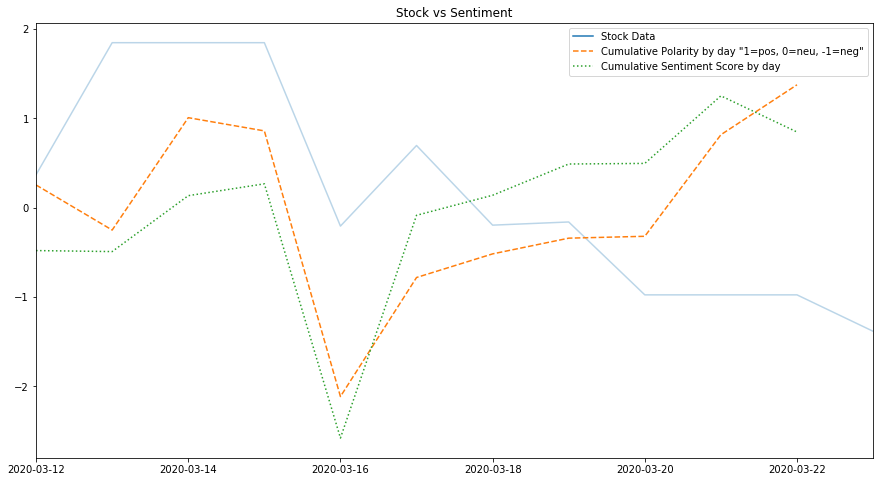

In [474]:
ax = plot_data.plot(style=['-', '--', ':'], figsize = (15,8), title = 'Stock vs Sentiment')
ax.lines[0].set_alpha(0.3)

As can be seen from the plots above, there seems to be a directional correlation between the news coverage and the stock price movement. This is observed in the data on March 13 and March 16 and March 17. However, data beyond that does not show strong correlation. Even though sentiment of the news has improved, the market still continues to drop